# Spatial Validation CESM LME

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild
import LIM_stats_kb as statskb

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [4]:
plt.rcParams['figure.dpi']=300

In [5]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    elif 'lme' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    elif 'lme' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'
    elif 'lme' in exp_setup['train_dsource']: 
        texp = 'LME'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'
    elif 'lme' in exp_setup['valid_dsource']: 
        vexp = 'LME'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'lme' in exp_setup['train_dsource']: 
        tmod = 'CESM'

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'lme' in exp_setup['valid_dsource']: 
        vmod = 'CESM'

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [6]:
def load_validation_data(var, exp_setup, remove_climo=True, detrend=True, verbose=True):
    ## LOad Truth data: 
    fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])
    v = {}
    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
    #        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
    if tecut <=0: 
        tecut = False
    print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=remove_climo, detrend=detrend, 
                               verbose=verbose,tscut=int(exp_setup['nyears_startvalid']/12), 
                               tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'])

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var = X_var/100
    
    return X_var

In [7]:
def calc_validation_stats_spatial(lag_int,var,X_var,exp_setup,forecast,LIMd):
    ## Calculate validation statistics: 
    [truth_anom, 
     forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup['mo'],X_var,
                                                            forecast['x_forecast_dcomp'],
                                                            LIMd_is['var_dict'],insamp=exp_setup['Insamp'])


    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))

    corr=np.zeros(truth_anom.shape[0])
    ce=np.zeros(truth_anom.shape[0])

    for i in range(truth_anom.shape[0]):
        corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
        ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))

    forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

    rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

    corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    
    return corr_2d, ce_2d, rmse_2d

In [8]:
def plot_spatial_validation(ax, variable, lat, lon, title): 

        ax.set_title(title, fontsize=16)
        ax.coastlines()
        
        Var, Lon = add_cyclic_point(variable, coord=lon)
        new_lon2d, new_lat2d = np.meshgrid(Lon, lat)
        
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())

        cf = ax.pcolormesh(new_lon2d, new_lat2d, Var ,cmap='RdBu_r', 
                           transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
        fig.colorbar(cf, ax=ax)
        
        return 

In [9]:
def pop_add_cyclic(var,latin,lonin):
    '''
    var = (nlat,nlon)
    latin = (nlat,nlon)
    latout = (nlat,nlon)
    '''
    
    nj = latin.shape[0]
    ni = lonin.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = lonin
    tlat = latin
    
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)    
    lon  = np.concatenate((tlon, tlon + 360.), 1)
    lon = lon[:, xL:xR]

    if ni == 320:
        lon[367:-3, 0] = lon[367:-3, 0] + 360.        
    lon = lon - 360.
    
    lon = np.hstack((lon, lon[:, 0:1] + 360.))
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8

    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    # determine and sort other dimensions
    field = var
    field = np.concatenate((field, field), axis=1)
    field = field[..., :, xL:xR]
    field = np.concatenate((field, field[..., :, 0:1]), axis=1)       
            
    return field,lat,lon

In [10]:
ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
ntrunc_sic = 50
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0
lags = [1,2,3,4,5,6,7,8]

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
lag_int = 1

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','zg','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid/'

In [11]:
folder = 'last_millennium/'
var_names = (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)
var='sic'

# filename_os = ('LIMcast_'+model+'_002_ntrain_850_1650'+
#                '_validyrs_1651_1850_'+var_names+'_20211202.pkl')
# filename_is = ('LIMcast_'+model+'_002_ntrain_850_1650'+
#                '_validyrs_0851_1050_'+var_names+'_20211202.pkl')

filename_os = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_'+
               '1651_1850_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
# filename_os = ('LIMcast_cesm_lme_Amon_ntrain_850_1650_cesm_lme_Amon_validy_'+
#                '1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20211202.pkl')
filename_is2 = ('LIMcast_cesm_lme_002_ntrain_850_1650_cesm_lme_validy_'+
               '0851_1050_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')
filename_is = ('LIMcast_cesm_lme_002_ntrain_850_1650_cesm_lme_validy_'+
               '0851_1050_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202_2.pkl')

print('Loading '+data_dir+folder+filename_is)

experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))
experiment_is =  pickle.load(open(data_dir+folder+filename_is, 'rb'))
experiment_is2 =  pickle.load(open(data_dir+folder+filename_is2, 'rb'))

LIMd_is = experiment_is['LIMd']
exp_setup_is = experiment_is['forecast']['exp_setup']
forecast_is = experiment_is['forecast']
forecast_validation_lags_is = experiment_is['forecast_validation_lags']
ar1cast_lags_is = experiment_is['ar1cast_lags']

LIMd_is2 = experiment_is2['LIMd']
exp_setup_is2 = experiment_is2['forecast']['exp_setup']
forecast_is2 = experiment_is2['forecast']
forecast_validation_lags_is2 = experiment_is2['forecast_validation_lags']
ar1cast_lags_is2 = experiment_is2['ar1cast_lags']

LIMd_os = experiment_os['LIMd']
exp_setup_os = experiment_os['forecast']['exp_setup']
forecast_os = experiment_os['forecast']
forecast_validation_lags_os = experiment_os['forecast_validation_lags']
ar1cast_lags_os = experiment_os['ar1cast_lags']

[tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
 vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
[tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
 vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    

Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_cesm_lme_validy_0851_1050_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202_2.pkl


Text(0.5, 1.0, 'Sea-ice Concentration')

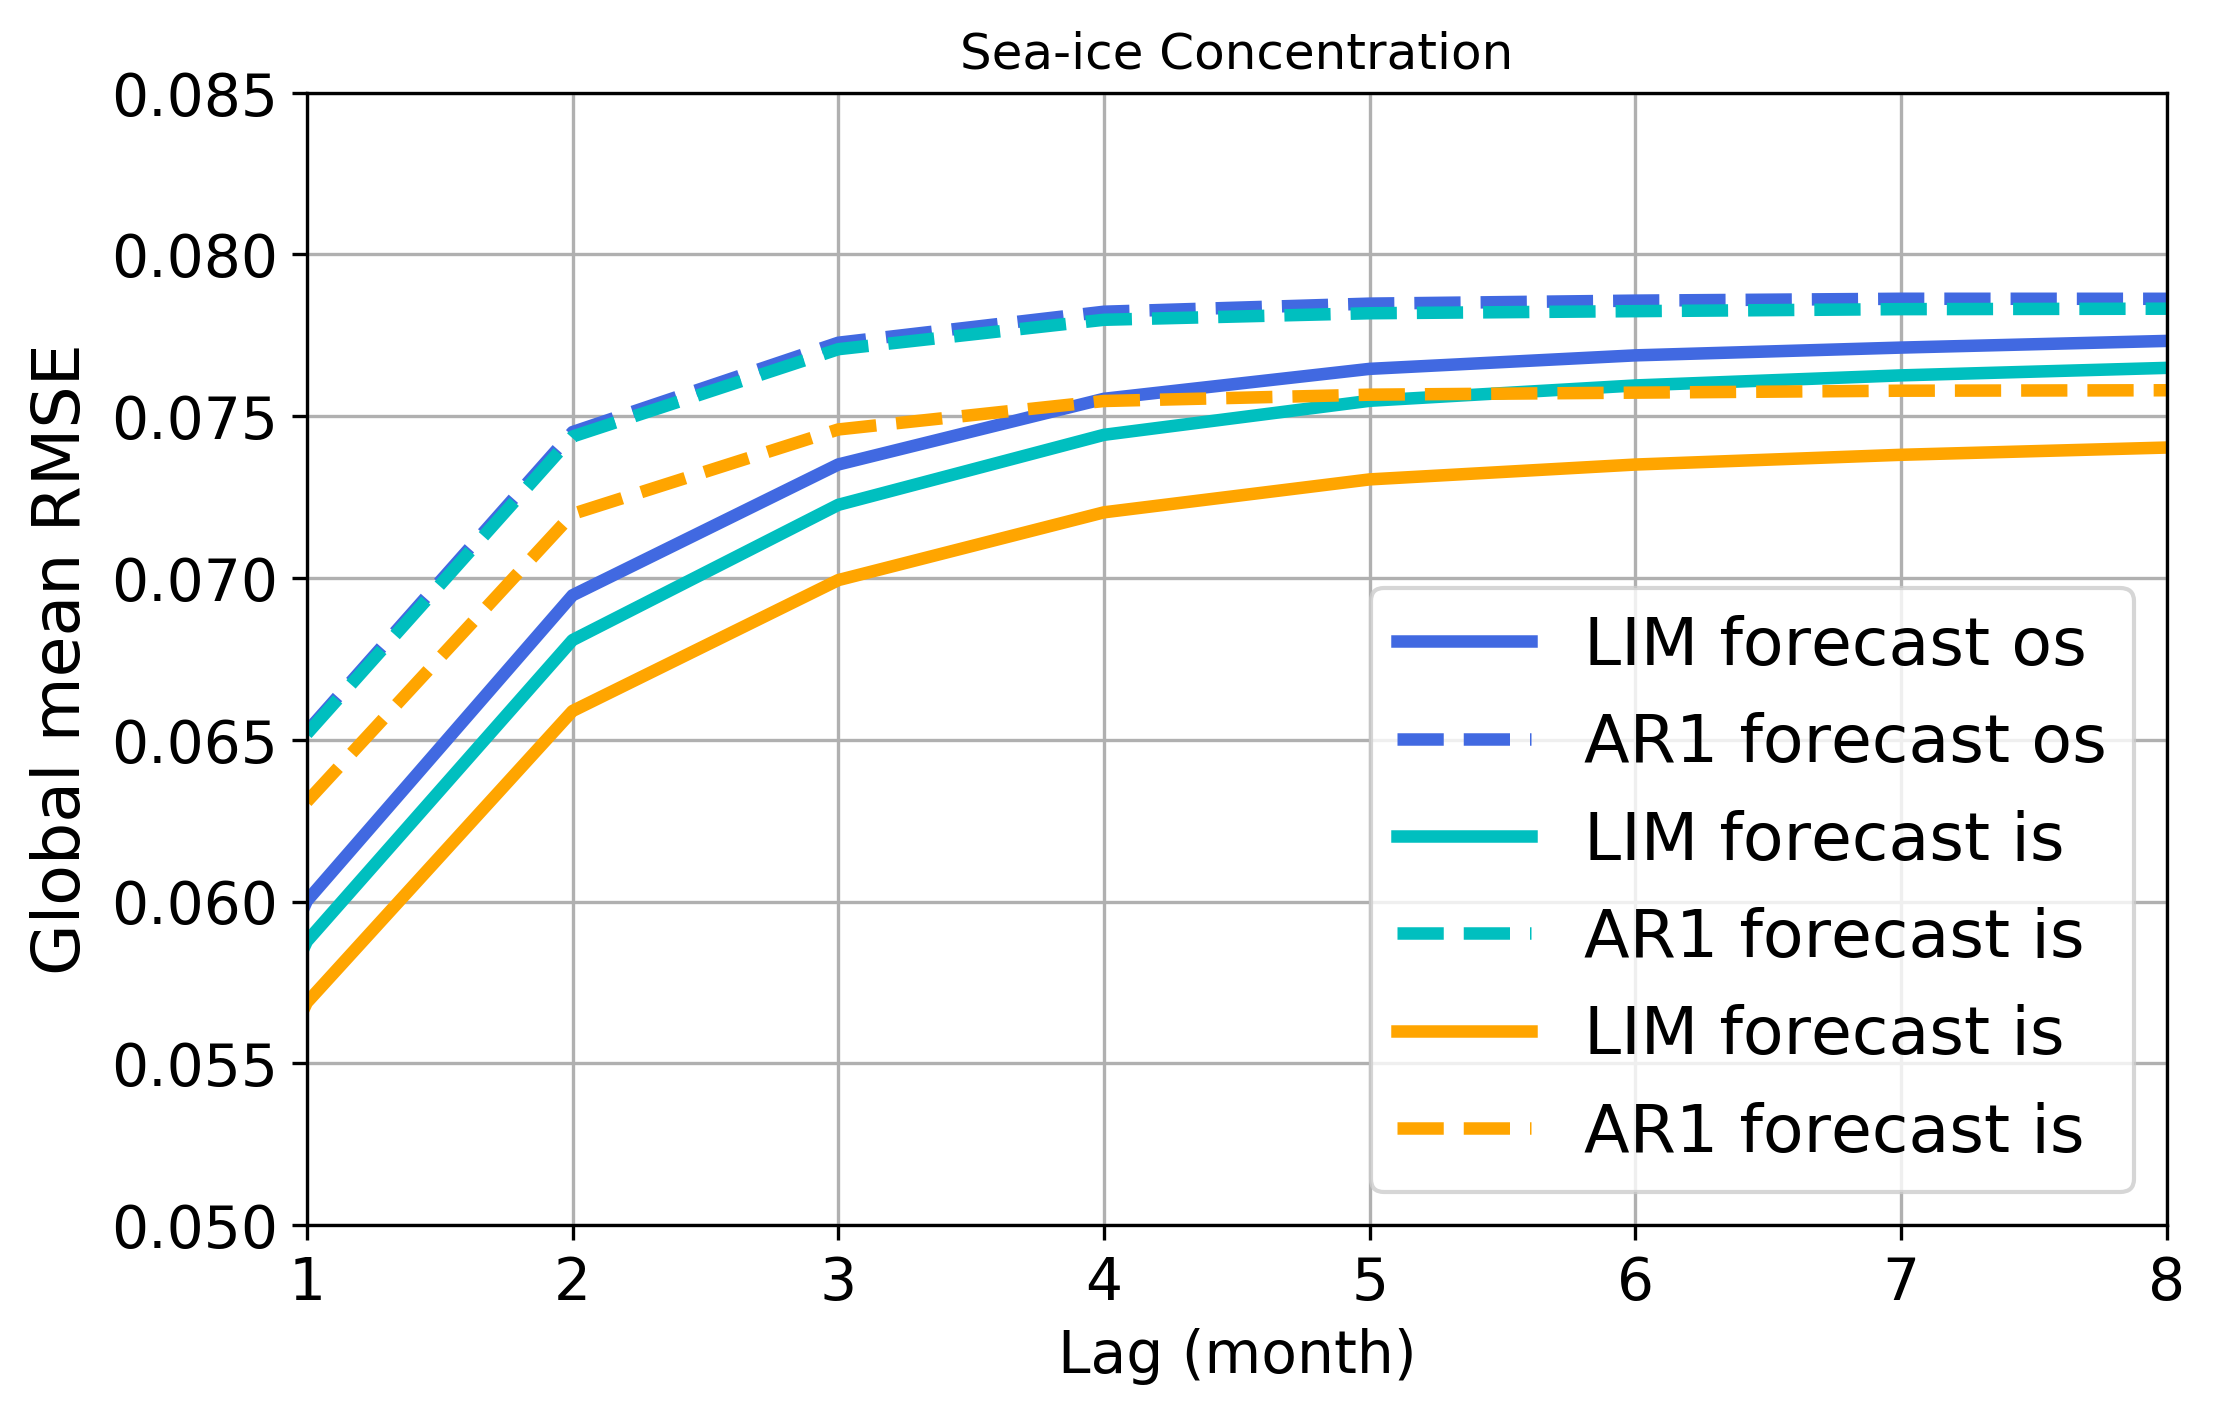

In [12]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast os', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_os['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast os', color='royalblue', linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast is', color='c', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_is['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast is', color='c', linewidth=3, linestyle='--')

plt.plot(np.arange(0,9,1),forecast_validation_lags_is2['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast is', color='orange', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_is2['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast is', color='orange', linewidth=3, linestyle='--')

plt.ylim(0.05,0.085)
plt.xlim(1,8)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='lower right',fontsize=16)
plt.title('Sea-ice Concentration')

In [13]:
# Northern hemisphere values
# ax[0].axhline(1.28, color='m',linewidth=2)
# ax[1].axhline(237, color='m',linewidth=2)
# ax[2].axhline(28.2, color='m',linewidth=2)
# ax[3].axhline(0.51, color='m',linewidth=2)
# ax[4].axhline(0.25, color='m',linewidth=2)
# ax[5].axhline(7.1, color='m',linewidth=2)

In [14]:
var_labels = {'tas':'TAS (K)','tos':'SST (K)','zg':'ZG500 (m)','psl':'PSL (Pa)','sit':'SIT (m)','sic':'SIC (%)'}
var_labels = {'tas':'Temperature (K)','tos':'Sea Surface Temperature (K)','zg':'Geopotential Height (500 hPa) (m)','psl':'Sea Level Pressure (Pa)','sit':'Sea Ice Thickness (m)','sic':'Sea Ice Concentration (%)'}

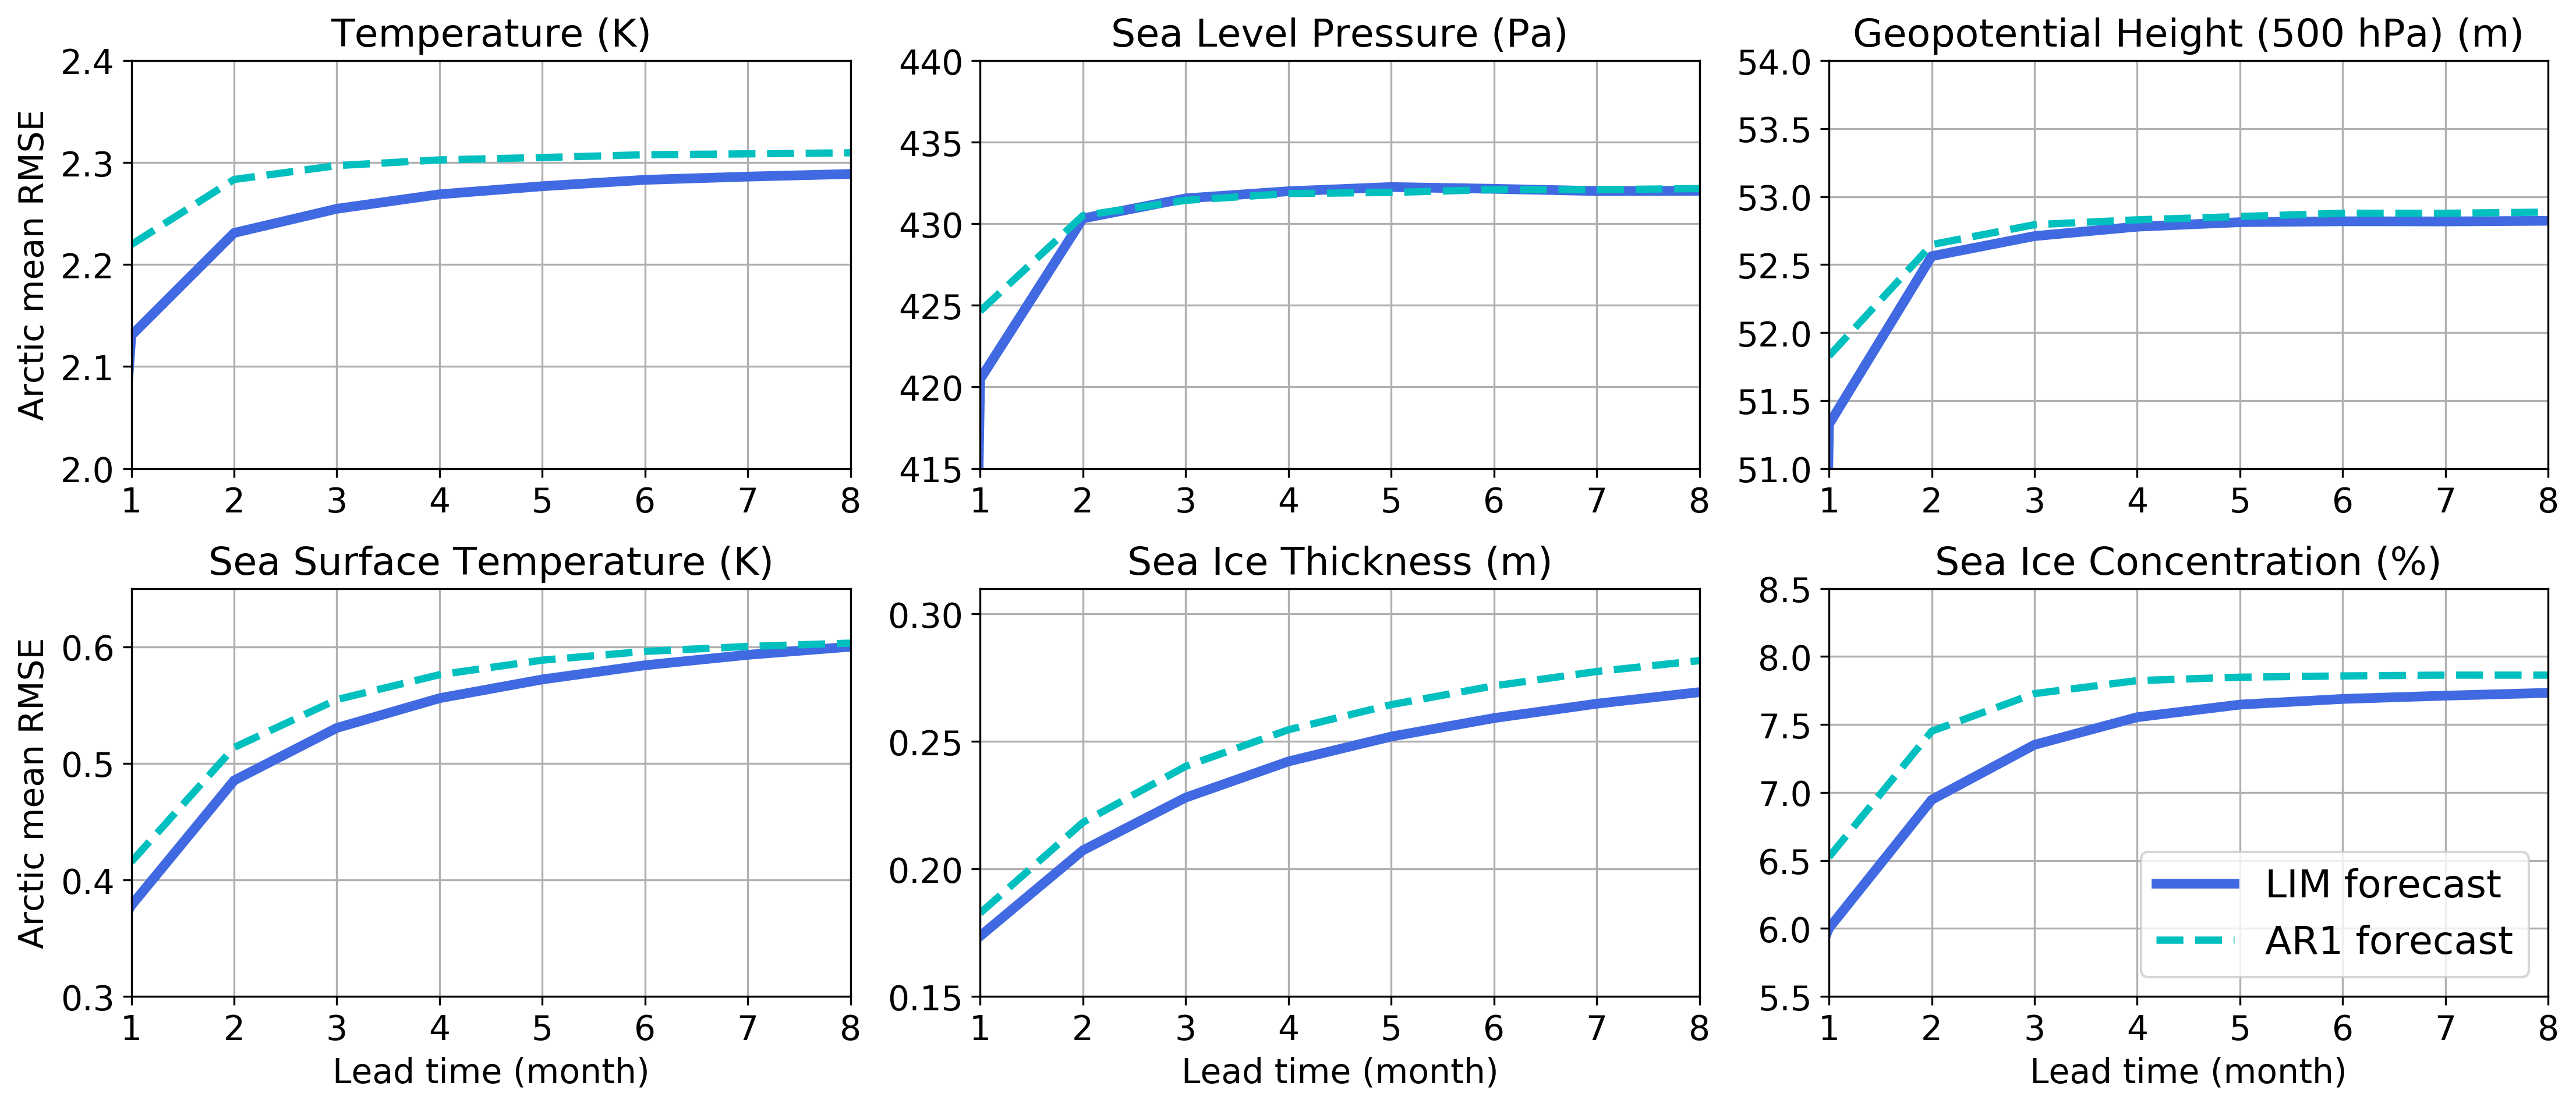

In [15]:
vmin = [2.0,415,51,0.3,0.15, 5.5]
vmax = [2.4,440,54,0.65,0.31, 8.5]
# vmin = [1.1,210,25,0.2,0.12, 5.5]
# vmax = [1.4,250,31,0.6,0.3, 7.5]

fig,axs = plt.subplots(2,3,figsize=(15,7))
ax = axs.flatten()

# ax[0].axhline(2.29, color='m',linewidth=2)
# ax[1].axhline(432, color='m',linewidth=2)
# ax[2].axhline(52.8, color='m',linewidth=2)
# ax[3].axhline(0.6, color='m',linewidth=2)
# ax[4].axhline(0.27, color='m',linewidth=2)
# ax[5].axhline(7.7, color='m',linewidth=2)

for i,var in enumerate(exp_setup_os['limvars']):
    ax[i].grid(axis='both')
    if 'sic' in var:
        ax[i].plot(np.arange(0,9,1),forecast_validation_lags_os['validation_stats_lags'][var]['gm_rmse']*100, 
                 label='LIM forecast', color='royalblue', linewidth=4)
        ax[i].plot(np.arange(1,9,1),ar1cast_lags_os['validation_stats_ar1_lags'][var]['gm_rmse'][:-1]*100, 
                 label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    else: 
        ax[i].plot(np.arange(0,9,1),forecast_validation_lags_os['validation_stats_lags'][var]['gm_rmse'], 
             label='LIM forecast', color='royalblue', linewidth=4)
        ax[i].plot(np.arange(1,9,1),ar1cast_lags_os['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
                 label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    
    ax[i].set_xlim(1,8)
    ax[i].set_ylim(vmin[i],vmax[i])
    ax[i].set_title(var_labels[var], fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].set_xticks(np.arange(1,9,1))

# plt.ylim(0.05,0.085
ax[5].set_xlabel('Lead time (month)', fontsize=14)
ax[3].set_xlabel('Lead time (month)', fontsize=14)
ax[4].set_xlabel('Lead time (month)', fontsize=14)

# plt.ylabel('Global mean RMSE',fontsize=16)
ax[0].set_ylabel('Arctic mean RMSE', fontsize=14)
ax[3].set_ylabel('Arctic mean RMSE', fontsize=14)

ax[5].legend(loc='lower right',fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.suptitle('Out of Sample Validation: ', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

savename = './figures/LIM_skill_by_variable_os.png'
plt.savefig(savename, bbox_inches='tight')

## Spatial Performance: 

In [16]:
x_forecast_dcomp_is = np.zeros((len(exp_setup_is['lags']),LIMd_is['E3_all'].shape[0]+LIMd_is['E_sic'].shape[0],
                               forecast_is['x_forecast'].shape[2]))
nmodes_is = LIMd_is['E3_all'].shape[1]

for i,lag in enumerate(exp_setup_is['lags']):
        print('Lag '+ str(lag))
        x_forecast_dcomp_is[lag,:,:] = limkb.decompress_eof_separate_sic(forecast_is['x_forecast'][lag,:,:],
                                                                         nmodes_is,exp_setup_is['nmodes_sic'],
                                                                         LIMd_is['E3_all'],LIMd_is['E_sic'],
                                                                         exp_setup_is['limvars'],LIMd_is['var_dict'],
                                                                         LIMd_is['W_all'],Weights=exp_setup_is['Weight'],
                                                                         sic_separate=exp_setup_is['sic_separate'])

Lag 0
Lag 1
Lag 2
Lag 3
Lag 4
Lag 5
Lag 6
Lag 7
Lag 8


In [17]:
x_forecast_dcomp_os = np.zeros((len(exp_setup_os['lags']),LIMd_os['E3_all'].shape[0]+LIMd_os['E_sic'].shape[0],
                               forecast_os['x_forecast'].shape[2]))
nmodes_os = LIMd_os['E3_all'].shape[1]

for i,lag in enumerate(exp_setup_os['lags']):
        print('Lag '+ str(lag))
        x_forecast_dcomp_os[lag,:,:] = limkb.decompress_eof_separate_sic(forecast_os['x_forecast'][lag,:,:],
                                                                         nmodes_os,exp_setup_os['nmodes_sic'],
                                                                         LIMd_os['E3_all'],LIMd_os['E_sic'],
                                                                         exp_setup_os['limvars'],LIMd_os['var_dict'],
                                                                         LIMd_os['W_all'],Weights=exp_setup_os['Weight'],
                                                                         sic_separate=exp_setup_os['sic_separate'])

Lag 0
Lag 1
Lag 2
Lag 3
Lag 4
Lag 5
Lag 6
Lag 7
Lag 8


In [18]:
## LOad Truth data: 
var = 'sic'
fdic_valid = limkb.build_training_dic(exp_setup_is['valid_dsource'])
v = {}
tecut = int(exp_setup_is['nyears_startvalid']/12)+(exp_setup_is['nyearsvalid'])
#        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
if tecut <=0: 
    tecut = False
print('tecut = '+str(tecut) +', tscut = '+str(exp_setup_is['nyears_startvalid']/12))

X_var_is, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True,
                               tscut=int(exp_setup_is['nyears_startvalid']/12), tecut=tecut, 
                               lat_cutoff=exp_setup_is['lat_cutoff'][var])
        
if var is 'sic':
    if np.nanmax(X_var_is)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var_is = X_var_is/100

tecut = 201, tscut = 1.0
Loading from sic
Loading from aIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 851 - 1050
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sate

In [19]:
## LOad Truth data: 
var = 'sic'
fdic_valid = limkb.build_training_dic(exp_setup_os['valid_dsource'])
v = {}
tecut = int(exp_setup_os['nyears_startvalid']/12)+(exp_setup_os['nyearsvalid'])
#        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
if tecut <=0: 
    tecut = False
print('tecut = '+str(tecut) +', tscut = '+str(exp_setup_os['nyears_startvalid']/12))

X_var_os, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True,
                           tscut=int(exp_setup_os['nyears_startvalid']/12), tecut=tecut, 
                           lat_cutoff=exp_setup_os['lat_cutoff'][var])
        
if var is 'sic':
    if np.nanmax(X_var_os)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var_os = X_var_os/100

tecut = 1001, tscut = 801.0
Loading from sic
Loading from aIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 1651 - 1850
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in 

In [20]:
## Calculate validation statistics: 
[truth_anom_is, 
 forecast_anom_is] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup_is['mo'],X_var_is,
                                                           x_forecast_dcomp_is,
                                                           LIMd_is['var_dict'],insamp=exp_setup_is['Insamp'])


print('Truth_anom shape: '+str(truth_anom_is.shape))
print('Forecast_anom shape: '+str(forecast_anom_is.shape))

corr=np.zeros(truth_anom_is.shape[0])
ce=np.zeros(truth_anom_is.shape[0])

for i in range(truth_anom_is.shape[0]):
    corr[i] = np.corrcoef(truth_anom_is[i,:],np.nan_to_num(forecast_anom_is[i,:]))[0,1]
    ce[i] = LMR_utils.coefficient_efficiency(truth_anom_is[i,:],np.nan_to_num(forecast_anom_is[i,:]))
    
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

rmse = np.sqrt(np.nanmean((truth_anom_is-forecast_anom_is)**2,axis=1))
var_truth = np.nanvar(truth_anom_is,axis=1)
var_forecast = np.nanvar(forecast_anom_is,axis=1)

corr_2d_is = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
ce_2d_is = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
rmse_2d_is = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
var_truth_is_2d = np.reshape(var_truth,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
var_forecast_is_2d = np.reshape(var_forecast,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))

Trained using all months...


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py:574: RuntimeWarning: Mean of empty slice
  truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]


Truth_anom shape: (30720, 2399)
Forecast_anom shape: (30720, 2399)


/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/kalman2/mkb22/pyLMR/LMR_utils.py:1397: RuntimeWarning: divide by zero encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/kalman2/mkb22/pyLMR/LMR_utils.py:1396: RuntimeWarning: Mean of empty slice
  denom = np.nansum(np.power(ref-np.nanmean(ref,axis=0),2),axis=0)
/home/disk/kalman2/mkb22/pyLMR/LMR_utils.py:1397: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/disk/chaos/mkb22/anaconda2/e

In [21]:
truth_anom_os_3d = np.reshape(truth_anom_os,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1],truth_anom_os.shape[1]))
forecast_anom_os_3d = np.reshape(np.nan_to_num(forecast_anom_os),(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1],truth_anom_os.shape[1]))

NameError: name 'truth_anom_os' is not defined

In [ ]:
plt.plot(np.nan_to_num(truth_anom_os_3d[25,200,:]))
plt.plot(forecast_anom_os_3d[25,200,:])
plt.plot(np.nan_to_num(truth_anom_os_3d[25,200,:]))

In [ ]:

plt.plot(forecast_anom_os_3d[65,40,:])
plt.plot(np.nan_to_num(truth_anom_os_3d[65,40,:]))

In [ ]:
np.nanvar(truth_anom_os_3d[65,40,:]), np.nanvar(truth_anom_os_3d[25,200,:])

In [ ]:
plt.pcolormesh(truth_anom_os_3d[:,:,100])
plt.scatter(40,65,color='m')

In [ ]:
plt.pcolormesh(forecast_anom_os_3d[:,:,100])
plt.scatter(50,75,color='m')

In [ ]:
ce_2d_os[40,65]

In [24]:
LIMd_os['var_dict'][var]['lat'].shape

(96, 320)

In [22]:
## Calculate validation statistics: 
[truth_anom_os, 
 forecast_anom_os] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup_os['mo'],X_var_os,
                                                           x_forecast_dcomp_os,
                                                           LIMd_os['var_dict'],insamp=exp_setup_os['Insamp'])

print('Truth_anom shape: '+str(truth_anom_os.shape))
print('Forecast_anom shape: '+str(forecast_anom_os.shape))

corr=np.zeros(truth_anom_os.shape[0])
ce=np.zeros(truth_anom_os.shape[0])

for i in range(truth_anom_os.shape[0]):
    corr[i] = np.corrcoef(np.nan_to_num(truth_anom_os[i,:]),np.nan_to_num(forecast_anom_os[i,:]))[0,1]
    ce[i] = LMR_utils.coefficient_efficiency(np.nan_to_num(truth_anom_os[i,:]),np.nan_to_num(forecast_anom_os[i,:]))
    
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_os['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

rmse = np.sqrt(np.nanmean((truth_anom_os-forecast_anom_os)**2,axis=1))
var_truth = np.nanvar(truth_anom_os,axis=1)
var_forecast = np.nanvar(forecast_anom_os,axis=1)

corr_2d_os = np.reshape(corr,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lon'].shape[1]))
ce_2d_os = np.reshape(ce,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lon'].shape[1]))
rmse_2d_os = np.reshape(rmse,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lon'].shape[1]))
var_truth_os_2d = np.reshape(var_truth,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lon'].shape[1]))
var_forecast_os_2d = np.reshape(var_forecast,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lon'].shape[1]))

Trained using all months...


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py:574: RuntimeWarning: Mean of empty slice
  truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]


Truth_anom shape: (30720, 2399)
Forecast_anom shape: (30720, 2399)


/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/kalman2/mkb22/pyLMR/LMR_utils.py:1397: RuntimeWarning: divide by zero encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/kalman2/mkb22/pyLMR/LMR_utils.py:1397: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Degrees of freedom <= 0 for slice.


In [23]:
## Calculate validation statistics for climotology: 
    
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_os['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

rmse_climo = np.sqrt(np.nanmean((truth_anom_os-np.nanmean(truth_anom_os,axis=1)[:,np.newaxis])**2,axis=1))

rmse_climo_2d_os = np.reshape(rmse_climo,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lon'].shape[1]))

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [24]:
[truth_anom_os, 
 forecast_anom_os] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup_os['mo'],X_var_os,
                                                           x_forecast_dcomp_os,
                                                           LIMd_os['var_dict'],insamp=exp_setup_os['Insamp'])

print('Truth_anom shape: '+str(truth_anom_os.shape))
print('Forecast_anom shape: '+str(forecast_anom_os.shape))

corr=np.zeros(truth_anom_os.shape[0])
#ce=np.zeros(truth_anom_os.shape[0])

norm_truth = np.nan_to_num(truth_anom_os)/np.nanstd(truth_anom_os,axis=1)[:,np.newaxis]
norm_forecast = np.nan_to_num(forecast_anom_os)/np.nanstd(forecast_anom_os,axis=1)[:,np.newaxis]

for i in range(truth_anom_os.shape[0]):
    corr[i] = np.corrcoef(norm_truth[i,:],norm_forecast[i,:])[0,1]
#    ce[i] = LMR_utils.coefficient_efficiency(norm_truth[i,:],norm_forecast[i,:])
    
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_os['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

rmse = np.sqrt(np.nanmean((norm_truth-norm_forecast)**2,axis=1))

corr_norm_2d_os = np.reshape(corr,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lon'].shape[1]))
rmse_norm_2d_os = np.reshape(rmse,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lon'].shape[1]))

Trained using all months...


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py:574: RuntimeWarning: Mean of empty slice
  truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]


Truth_anom shape: (30720, 2399)
Forecast_anom shape: (30720, 2399)


/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


In [95]:
norm_truth.shape, norm_forecast.shape

((30720, 2399), (30720, 2399))

In [107]:
test = np.reshape(norm_truth[:,0]-norm_forecast[:,0],(LIMd_os['var_dict'][var]['lat'].shape[0],
                                   LIMd_os['var_dict'][var]['lon'].shape[1]))

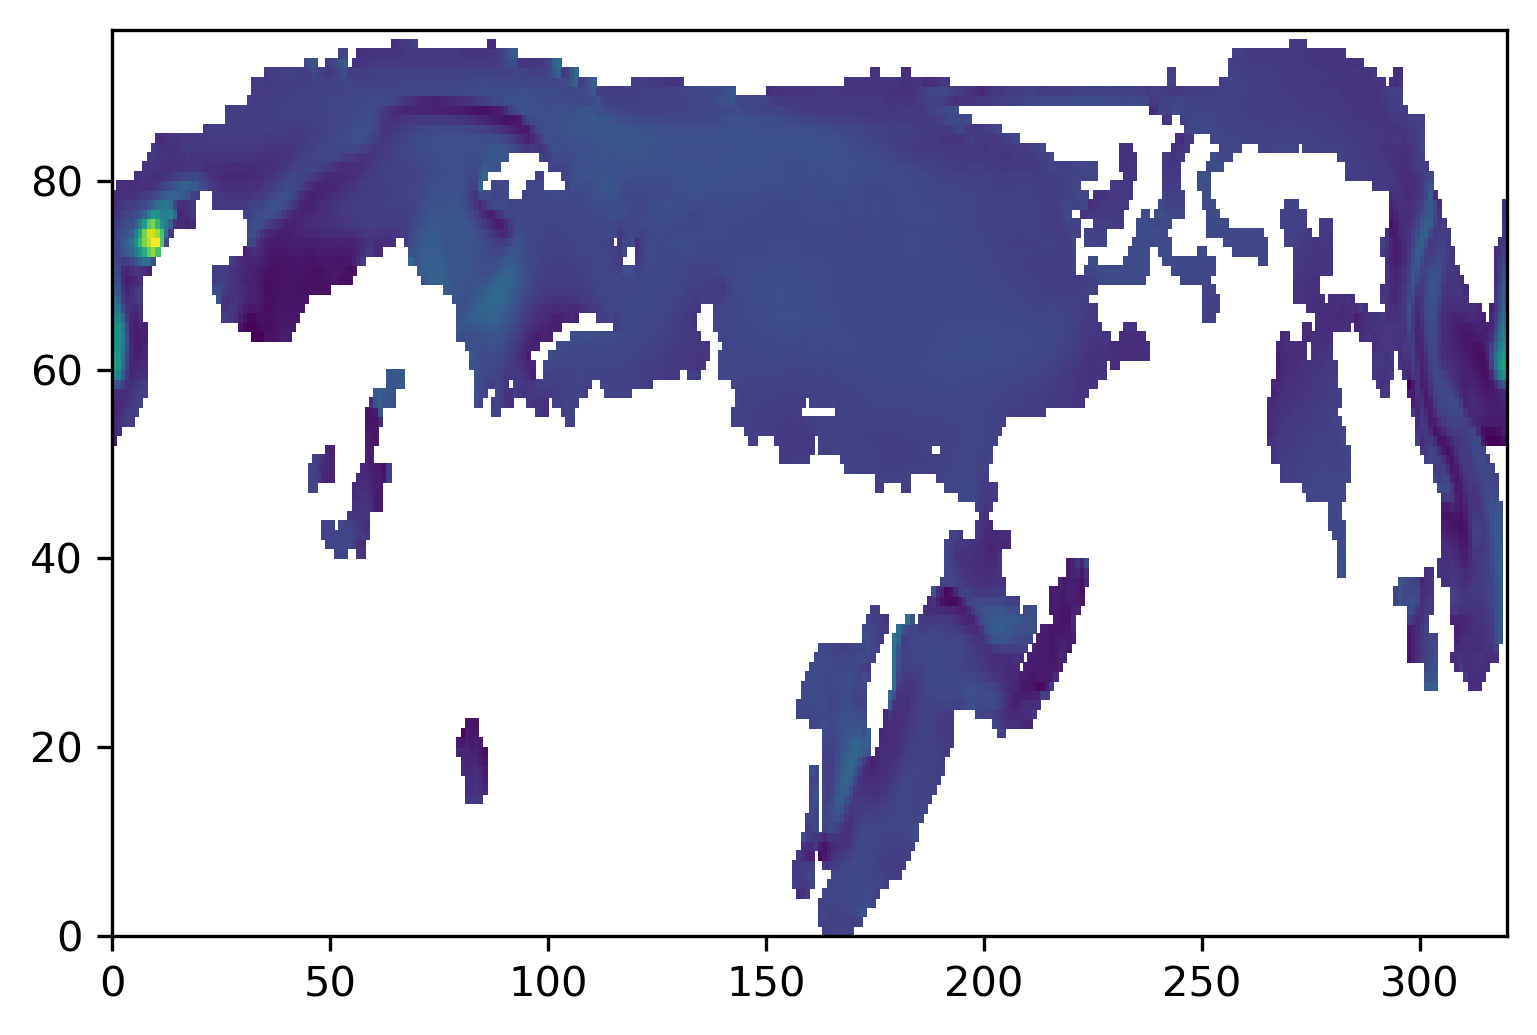

In [108]:
plt.pcolormesh(test)

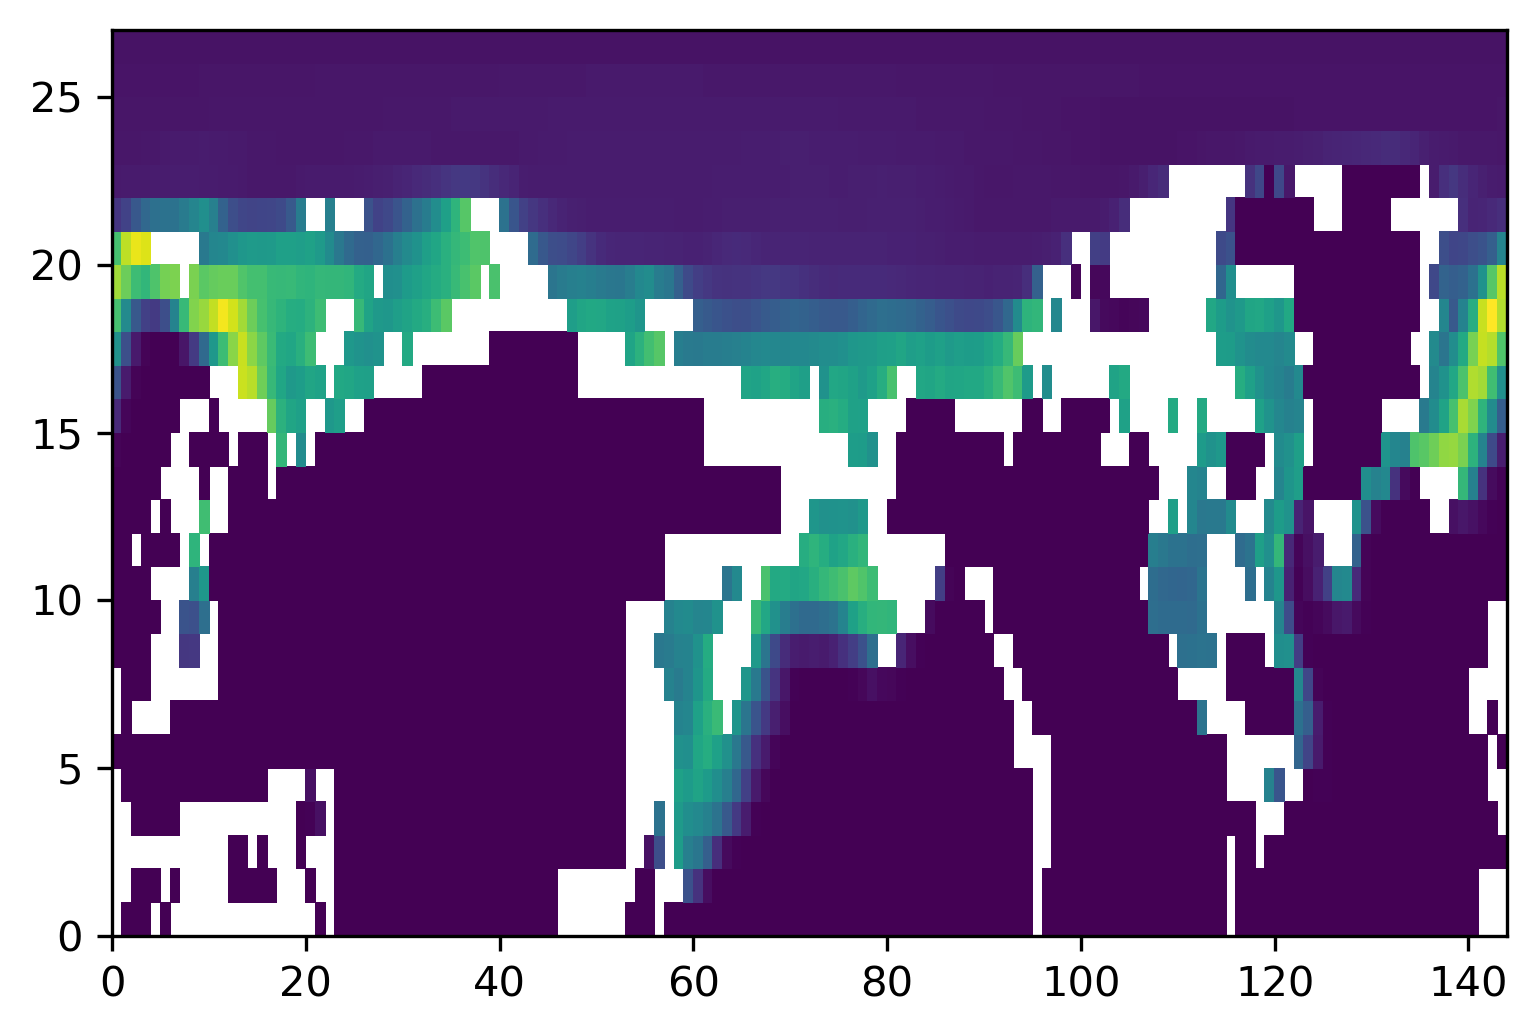

In [23]:
plt.pcolormesh(rmse_2d_os)

In [25]:
cmap = matplotlib.cm.get_cmap('RdBu_r')

import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
               'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                cmap(np.linspace(minval, maxval, n)))
    return new_cmap

new_cmap = truncate_colormap(cmap, minval=0.5, maxval=1.0, n=100)

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


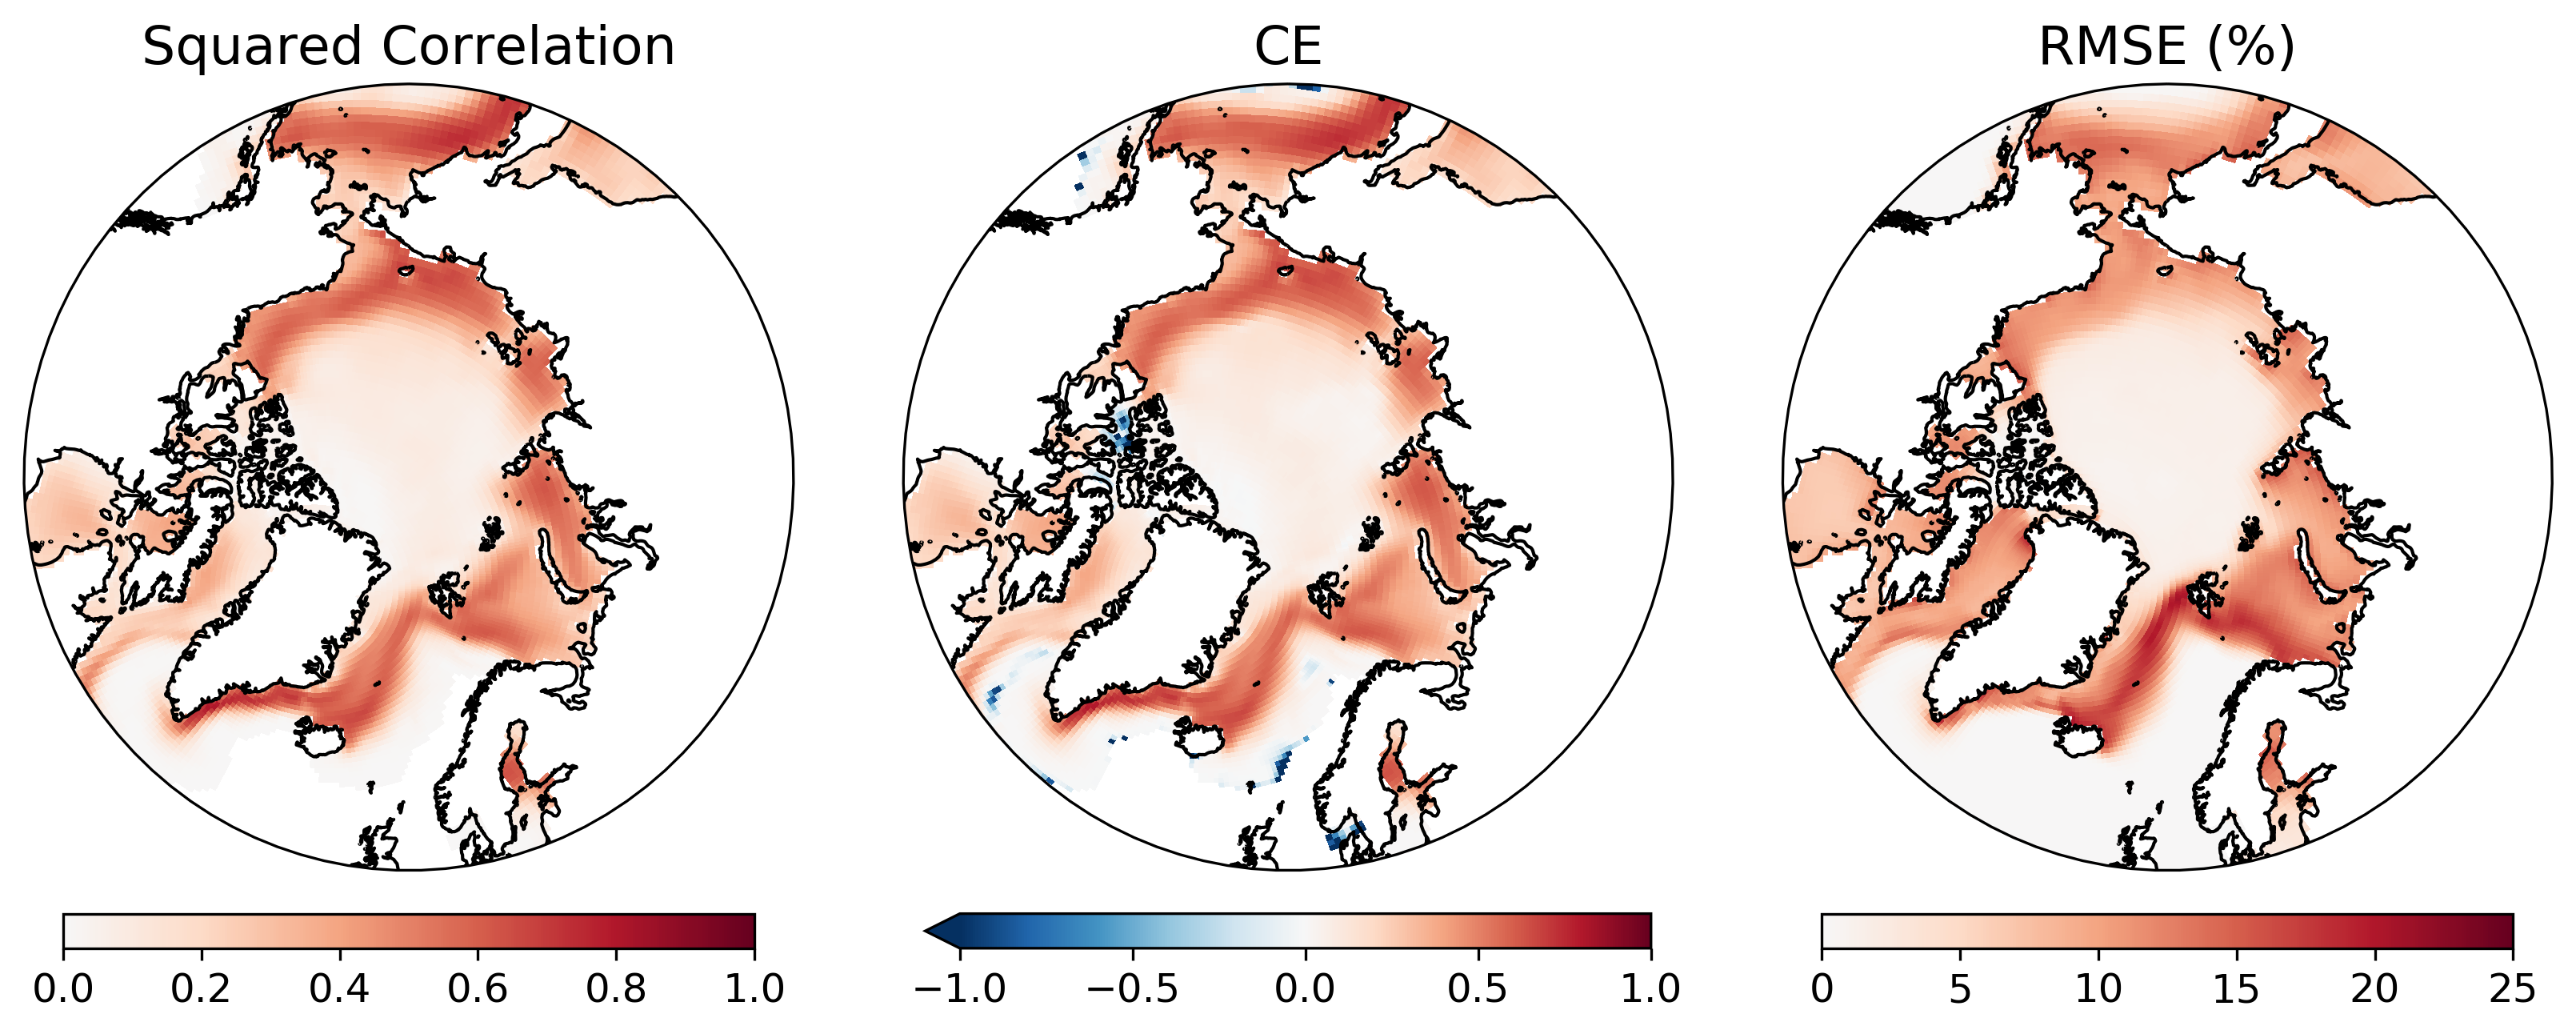

In [26]:
modes = [corr_2d_os**2,ce_2d_os,rmse_2d_os*100]
vmin_modes = [0,-1,0,-0.1,-0.1]
vmax_modes = [1,1,25,0.1,0.1]
colors = [new_cmap,'RdBu_r',new_cmap, new_cmap, new_cmap]
mode_name = ['Squared Correlation','CE', 'RMSE (%)']
extent = ['neither', 'min', 'neither']

lonn = np.nan_to_num(LIMd_os['var_dict']['tos']['lon'])
latt = np.nan_to_num(LIMd_os['var_dict']['tos']['lat'])

fig, axs = plt.subplots(1,3,figsize=(12,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
#    Mode, Lon = add_cyclic_point(mode, coord=lonn[0,:])
#    new_lon2d, new_lat2d = np.meshgrid(lonn, latt)
    
    [field,latcyc,loncyc] = pop_add_cyclic(mode,latt,lonn)
#    field,loncyc = add_cyclic_point(mode, coord=lonn)
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    cf = ax[i].pcolormesh(loncyc,latcyc,
                          field,cmap=colors[i], shading='nearest',
                          transform=ccrs.PlateCarree(),
                          vmin=vmin_modes[i],vmax=vmax_modes[i])
    cb = fig.colorbar(cf, ax=ax[i], orientation='horizontal',fraction=0.04, pad=0.05, extend=extent[i])
    
    cb.ax.tick_params(labelsize=12) 
#    cb.set_label(units,fontsize=12)
    
# plt.suptitle(('LIM trained on all months: \n Training years: '+
#               tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_filename']['sic'][-22:-13]+
#               '\nValidation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is), fontsize=16)
fig.tight_layout(rect=[0, 0.0, 0.9, 0.90])

#ax[1].scatter(0,10,color='m')

# savename = './figures/LIM_spatial_skill_os.png'
# plt.savefig(savename, bbox_inches='tight')

In [91]:
norm_truth_var = np.nanvar(np.nan_to_num(truth_anom_os),axis=1)
norm_forecast_var = np.nanvar(np.nan_to_num(forecast_anom_os),axis=1)

norm_truth_var = np.array([np.float(i) for i in norm_truth_var])
norm_forecast_var = np.array([np.float(i) for i in norm_forecast_var])

norm_truth_var_2d = np.reshape(norm_truth_var,(LIMd_os['var_dict'][var]['lat'].shape[0],
                                               LIMd_os['var_dict'][var]['lon'].shape[1]))
norm_forecast_var_2d = np.reshape(norm_forecast_var,(LIMd_os['var_dict'][var]['lat'].shape[0],
                                                     LIMd_os['var_dict'][var]['lon'].shape[1]))

norm_truth_var_2d_mask = np.where((norm_truth_var_2d<0.001),-1,1)
land_mask = np.where((norm_truth_var_2d<0.00001),0,1)
mask_hold = norm_truth_var_2d_mask*land_mask
mask = np.where(mask_hold<0,np.nan,mask_hold)

working on 0
new_cmap
working on 1
color string found. 
working on 2
new_cmap


/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


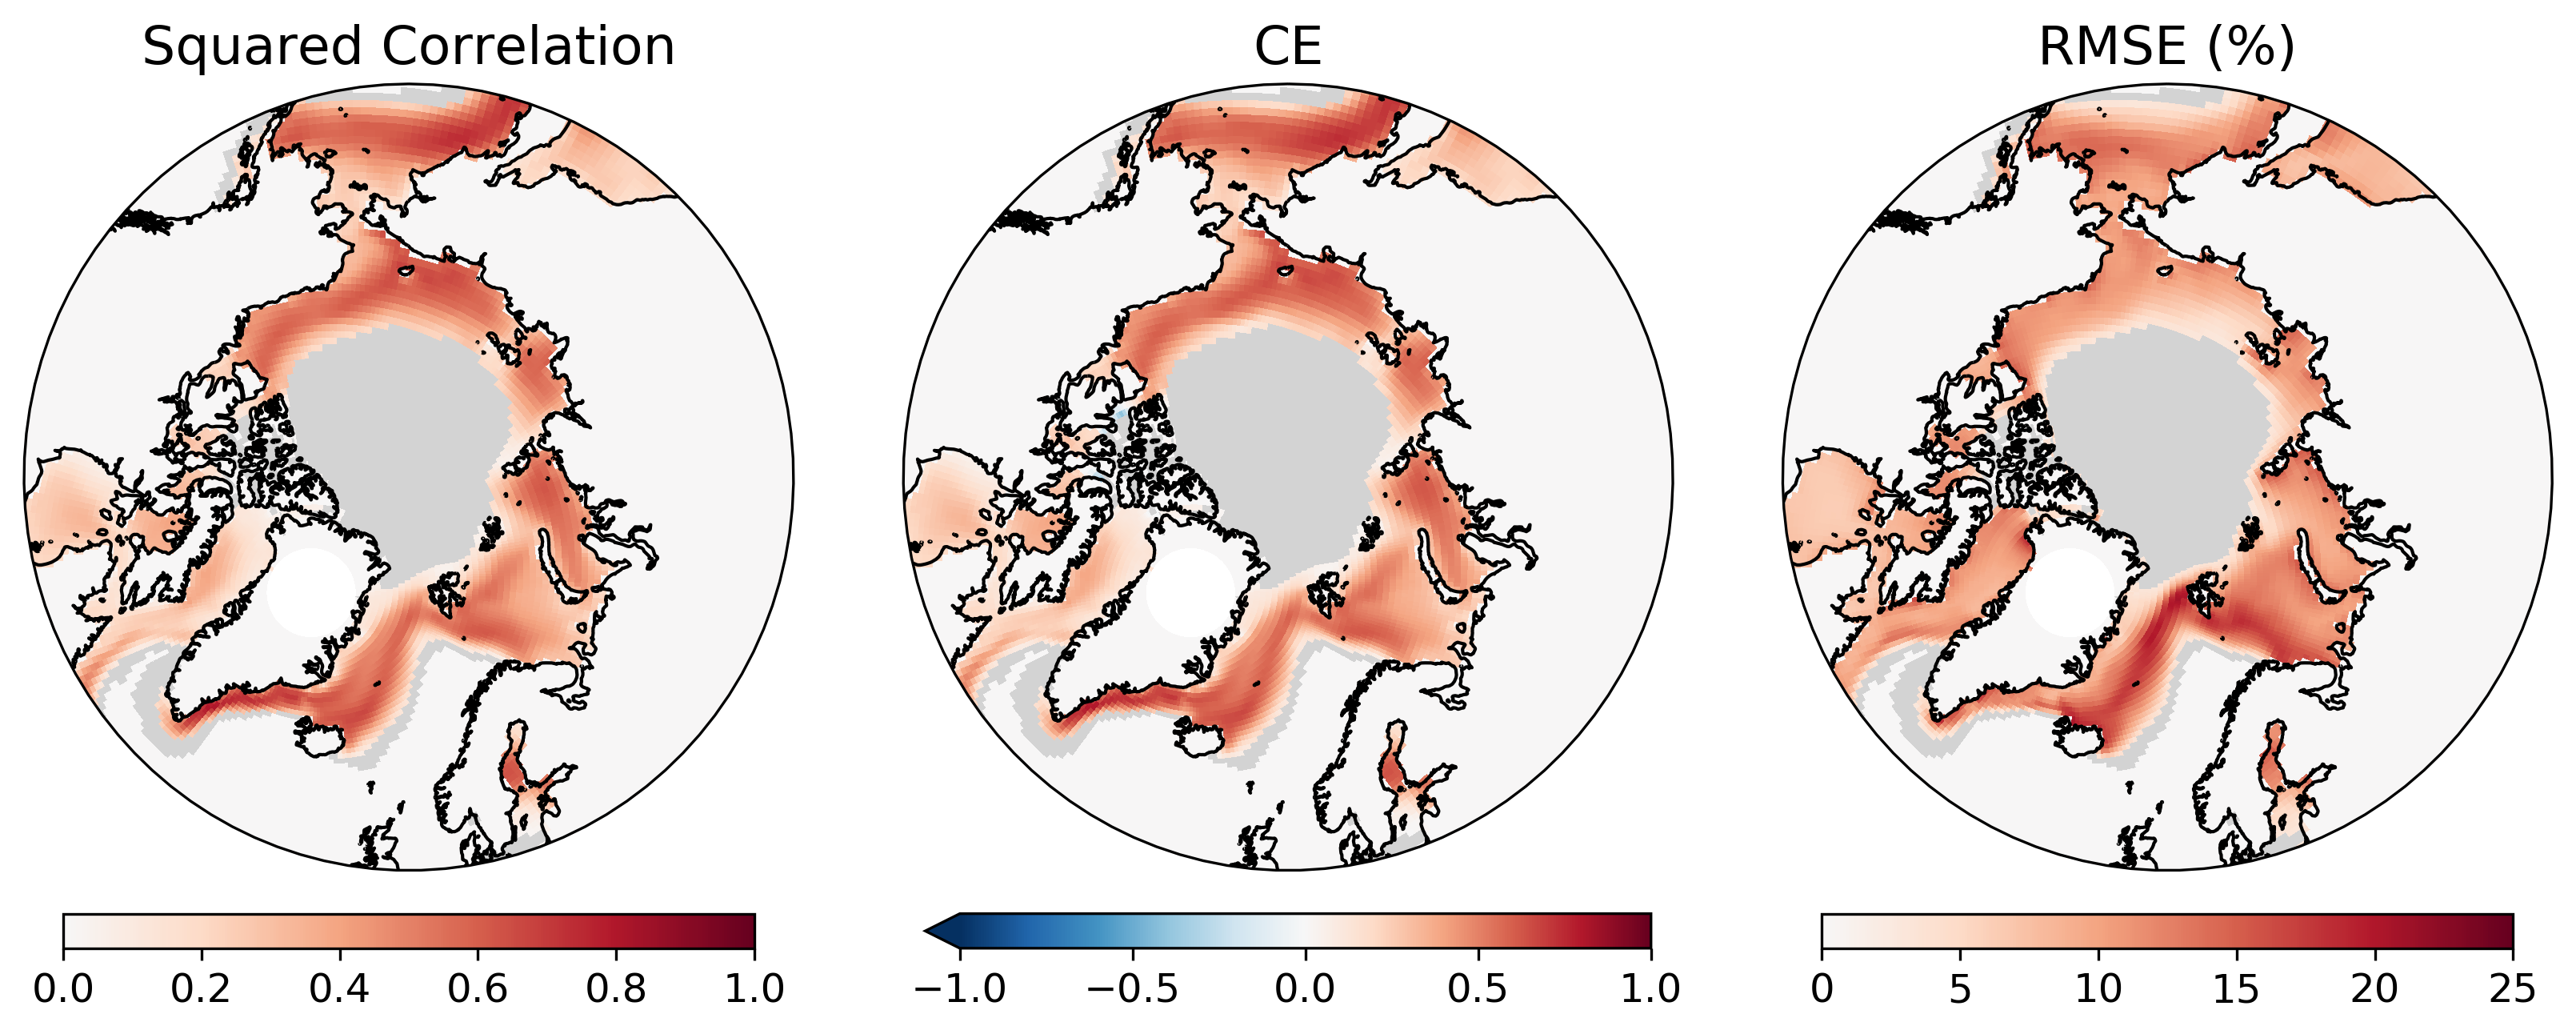

In [92]:
modes = [(np.nan_to_num(corr_2d_os)**2)*mask,np.nan_to_num(ce_2d_os)*mask,
         np.nan_to_num(rmse_2d_os)*100*mask]
vmin_modes = [0,-1,0,-0.1,-0.1]
vmax_modes = [1,1,25,0.1,0.1]
colors = [new_cmap,'RdBu_r',new_cmap, new_cmap, new_cmap]
mode_name = ['Squared Correlation','CE', 'RMSE (%)']
extent = ['neither', 'min', 'neither']

lonn = np.nan_to_num(LIMd_os['var_dict']['tos']['lon'])
latt = np.nan_to_num(LIMd_os['var_dict']['tos']['lat'])

fig, axs = plt.subplots(1,3,figsize=(12,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    print('working on '+str(i))
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
#    Mode, Lon = add_cyclic_point(mode, coord=lonn[0,:])
#    new_lon2d, new_lat2d = np.meshgrid(lonn, latt)

    mode_plot = np.ma.masked_where((norm_truth_var_2d<0.001), mode)
    
    [field,latcyc,loncyc] = pop_add_cyclic(mode_plot,latt,lonn)
#    field,loncyc = add_cyclic_point(mode, coord=lonn)
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    if isinstance(colors[i], str):
        print('color string found. ')
        new_cmap_plot = matplotlib.cm.get_cmap(colors[i])
        new_cmap_plot.set_bad(color='lightgray',alpha=1)
    else: 
        print('new_cmap')
        new_cmap_plot = new_cmap
        new_cmap_plot.set_bad(color='lightgray',alpha=1)
    
    cf = ax[i].pcolormesh(loncyc,latcyc,
                          field,cmap=new_cmap_plot, shading='nearest',
                          transform=ccrs.PlateCarree(),
                          vmin=vmin_modes[i],vmax=vmax_modes[i])
    cb = fig.colorbar(cf, ax=ax[i], orientation='horizontal',fraction=0.04, pad=0.05, extend=extent[i])
    
    cb.ax.tick_params(labelsize=12) 
#    cb.set_label(units,fontsize=12)
    
    new_cmap_plot=None
    
# plt.suptitle(('LIM trained on all months: \n Training years: '+
#               tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_filename']['sic'][-22:-13]+
#               '\nValidation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is), fontsize=16)
fig.tight_layout(rect=[0, 0.0, 0.9, 0.90])

#ax[1].scatter(0,10,color='m')

# savename = './figures/LIM_spatial_skill_os.png'
# plt.savefig(savename, bbox_inches='tight')

In [47]:
type((norm_truth_var_2d_mask)[0,80])

numpy.float64

In [45]:
type(np.float(norm_truth_var_2d_mask[0,80]))

float

In [39]:
type(np.nan)

float

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


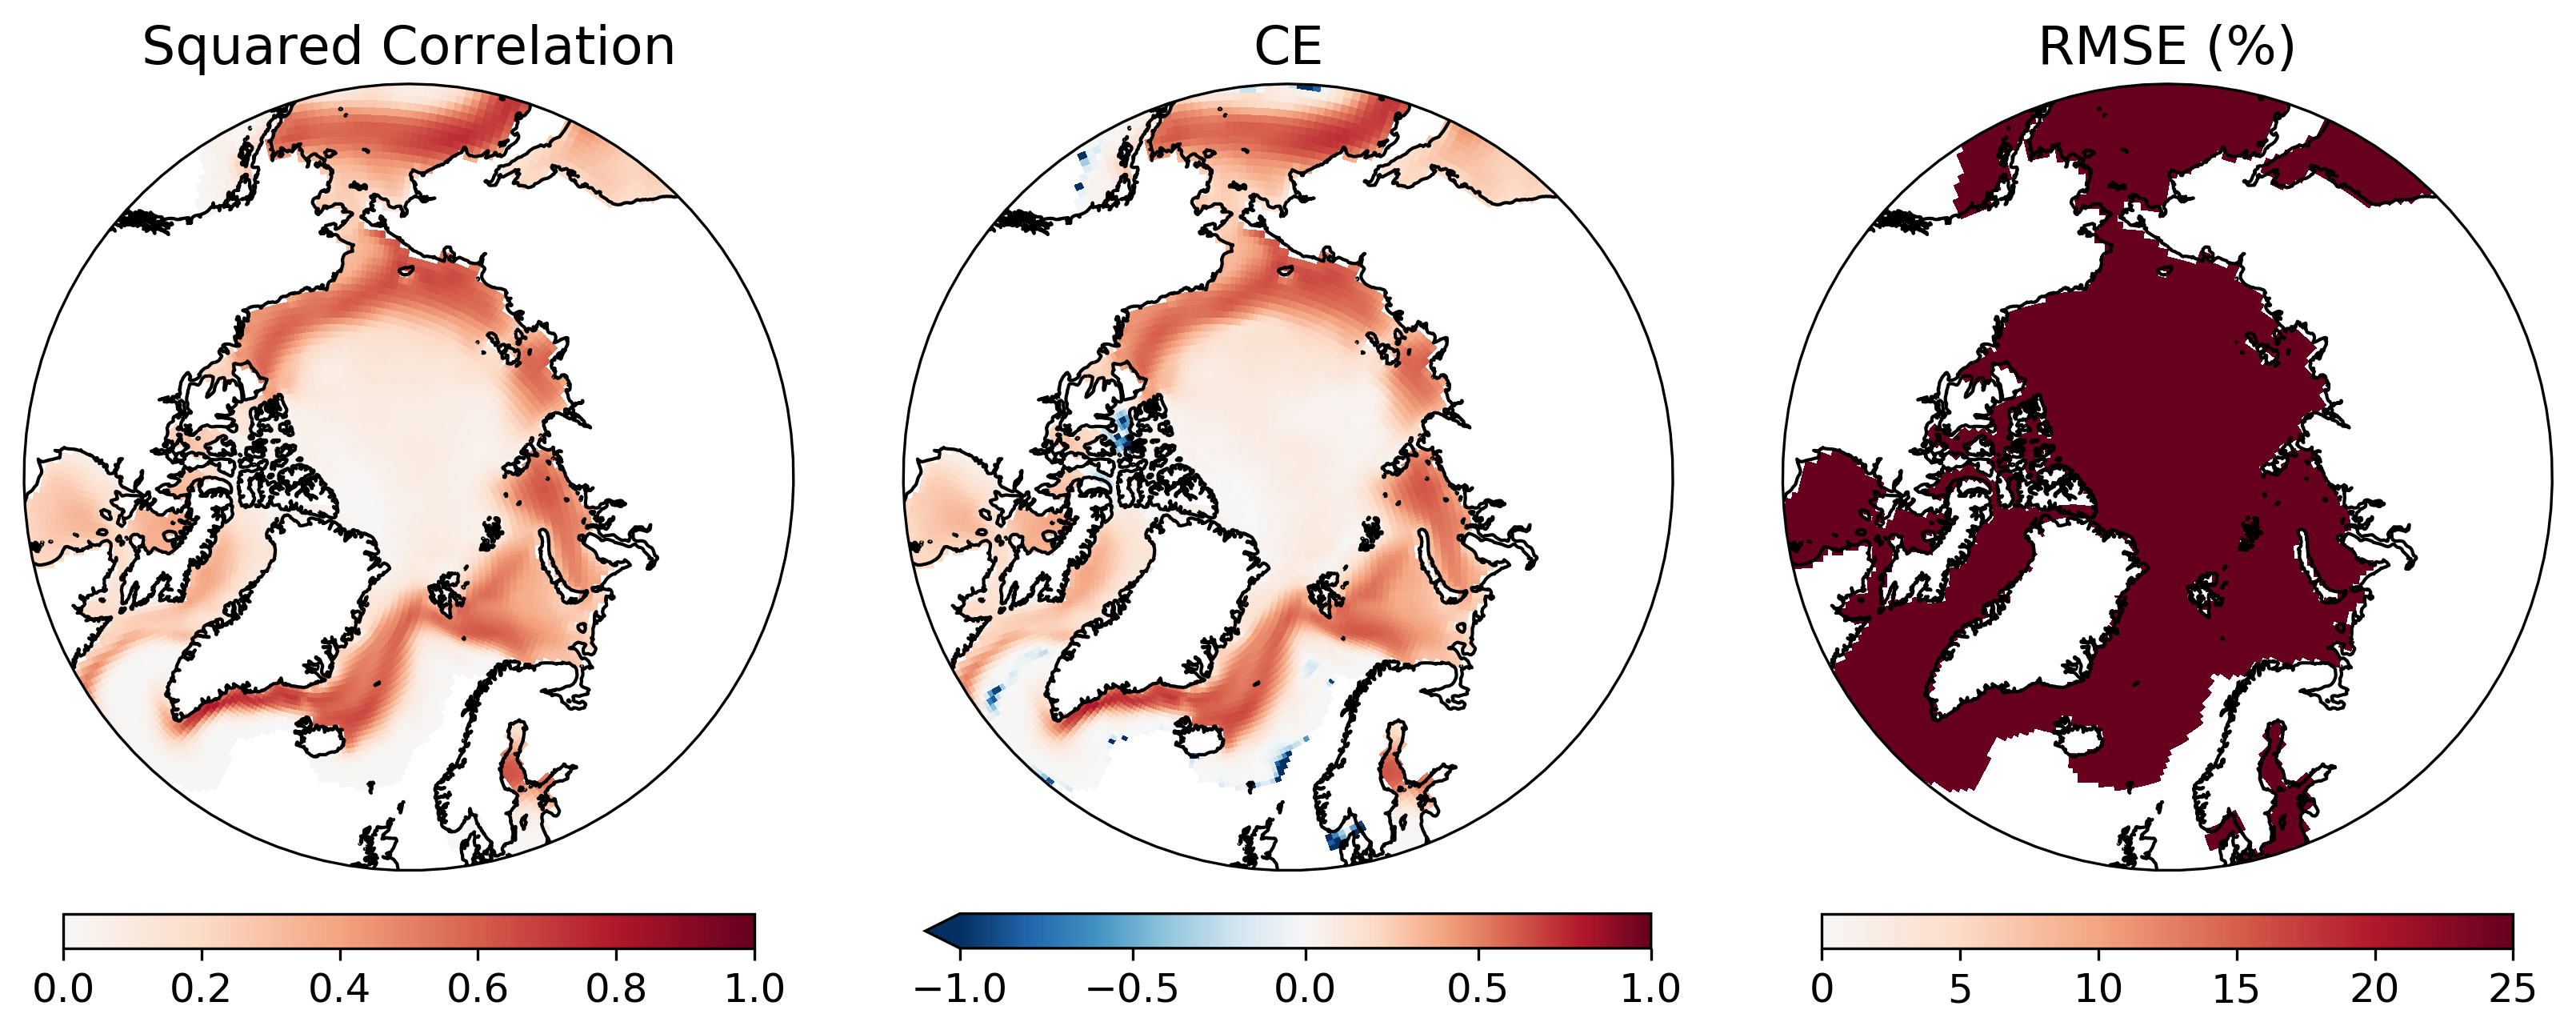

In [49]:
modes = [corr_norm_2d_os**2,ce_2d_os,rmse_norm_2d_os*100]
vmin_modes = [0,-1,0,-0.1,-0.1]
vmax_modes = [1,1,25,0.1,0.1]
colors = [new_cmap,'RdBu_r',new_cmap, new_cmap, new_cmap]
mode_name = ['Squared Correlation','CE', 'RMSE (%)']
extent = ['neither', 'min', 'neither']

lonn = np.nan_to_num(LIMd_os['var_dict']['tos']['lon'])
latt = np.nan_to_num(LIMd_os['var_dict']['tos']['lat'])

fig, axs = plt.subplots(1,3,figsize=(12,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
#    Mode, Lon = add_cyclic_point(mode, coord=lonn[0,:])
#    new_lon2d, new_lat2d = np.meshgrid(lonn, latt)
    
    [field,latcyc,loncyc] = pop_add_cyclic(mode,latt,lonn)
#    field,loncyc = add_cyclic_point(mode, coord=lonn)
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    cf = ax[i].pcolormesh(loncyc,latcyc,
                          field,cmap=colors[i], shading='nearest',
                          transform=ccrs.PlateCarree(),
                          vmin=vmin_modes[i],vmax=vmax_modes[i])
    cb = fig.colorbar(cf, ax=ax[i], orientation='horizontal',fraction=0.04, pad=0.05, extend=extent[i])
    
    cb.ax.tick_params(labelsize=12) 
#    cb.set_label(units,fontsize=12)
    
# plt.suptitle(('LIM trained on all months: \n Training years: '+
#               tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_filename']['sic'][-22:-13]+
#               '\nValidation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is), fontsize=16)
fig.tight_layout(rect=[0, 0.0, 0.9, 0.90])

#ax[1].scatter(0,10,color='m')

# savename = './figures/LIM_spatial_skill_os.png'
# plt.savefig(savename, bbox_inches='tight')

## AR1 forecast comparison: 

In [82]:
fdic_train = limkb.build_training_dic(exp_setup_os['train_dsource'])
fdic_valid = limkb.build_training_dic(exp_setup_os['valid_dsource'])

areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, lat_cutoff=exp_setup_os['lat_cutoff']['tas'],
                                                      remove_climo=False, detrend=False, verbose=False )
full_names, areawt_name, month_names = limbuild.load_full_names(dsource='Amon')

if len(exp_setup_os['limvars'])<=1:
    ar1_forecast_dcomp_lag = np.zeros((len(exp_setup_os['lags']),
                                       LIMd['E_sic'].shape[0],
                                       exp_setup_os['nyearsvalid']*12))
    ar1_factor_lag = np.zeros((len(exp_setup_os['lags']),LIMd_os['P_train'].shape[0]))
else: 
    ar1_forecast_dcomp_lag = np.zeros((len(exp_setup_os['lags']),
                                       LIMd_os['E3_all'].shape[0]+LIMd_is['E_sic'].shape[0],
                                       exp_setup_os['nyearsvalid']*12))
    ar1_factor_lag = np.zeros((len(exp_setup_os['lags']),LIMd_os['P_train'].shape[0]))

for l,lag in enumerate(exp_setup_os['lags'][1:]):
    forecast_ar1, ar1_factor = statskb.red_noise_forecast_ar1(LIMd_os['P_train'].T, 
                                                              forecast_os['P_train_valid'].T, lead=lag)

    if len(exp_setup_os['limvars'])<=1:
        nmodes=0
        ar1_forecast_dcomp = np.zeros((LIMd_os['E_sic'].shape[0],exp_setup_os['nyearsvalid']*12))
    else:
        nmodes = LIMd_os['E3_all'].shape[1]
        ar1_forecast_dcomp = np.zeros((LIMd_os['E3_all'].shape[0]+ LIMd_os['E_sic'].shape[0],
                                       exp_setup_os['nyearsvalid']*12))

    ar1_forecast_dcomp_lag[lag,:,lag:] = limkb.decompress_eof_separate_sic(forecast_ar1.T,nmodes,
                                                                           exp_setup_os['nmodes_sic'],
                                                                           LIMd_os['E3_all'],LIMd_os['E_sic'],
                                                                           exp_setup_os['limvars'],LIMd_os['var_dict'],
                                                                           LIMd_os['W_all'],Weights=exp_setup_os['Weight'],
                                                                           sic_separate=exp_setup_os['sic_separate'])
    ar1_factor_lag[lag,:] = ar1_factor 

Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Lead = 1
Lead = 2
Lead = 3
Lead = 4
Lead = 5
Lead = 6
Lead = 7
Lead = 8


In [83]:
[truth_anom_os, 
 ar1_anom_os] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup_os['mo'],X_var_os,
                                                      ar1_forecast_dcomp_lag,
                                                      LIMd_os['var_dict'],insamp=exp_setup_os['Insamp'])

print('Truth_anom shape: '+str(truth_anom_os.shape))
print('Forecast_anom shape: '+str(forecast_anom_os.shape))

corr=np.zeros(truth_anom_os.shape[0])
ce=np.zeros(truth_anom_os.shape[0])

for i in range(truth_anom_os.shape[0]):
    corr[i] = np.corrcoef(truth_anom_os[i,:],np.nan_to_num(ar1_anom_os[i,:]))[0,1]
    ce[i] = LMR_utils.coefficient_efficiency(truth_anom_os[i,:],np.nan_to_num(ar1_anom_os[i,:]))
    
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_os['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

rmse = np.sqrt(np.nanmean((truth_anom_os-ar1_anom_os)**2,axis=1))
var_forecast = np.nanvar(ar1_anom_os,axis=1)

corr_ar1_2d_os = np.reshape(corr,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1]))
ce_ar1_2d_os = np.reshape(ce,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1]))
rmse_ar1_2d_os = np.reshape(rmse,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1]))
var_ar1_forecast_os_2d = np.reshape(var_forecast,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1]))

Trained using all months...


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py:574: RuntimeWarning: Mean of empty slice
  truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]


Truth_anom shape: (30720, 2399)
Forecast_anom shape: (30720, 2399)


/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/kalman2/mkb22/pyLMR/LMR_utils.py:1397: RuntimeWarning: divide by zero encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/kalman2/mkb22/pyLMR/LMR_utils.py:1396: RuntimeWarning: Mean of empty slice
  denom = np.nansum(np.power(ref-np.nanmean(ref,axis=0),2),axis=0)
/home/disk/kalman2/mkb22/pyLMR/LMR_utils.py:1397: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


In [84]:
np.nanmax(corr_2d_os**2-corr_ar1_2d_os**2), np.nanmax((ce_2d_os-ce_ar1_2d_os)), np.nanmin((rmse_2d_os-rmse_ar1_2d_os))

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


(0.22888031761531838, 0.24185576525747587, -0.03831223812361012)

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


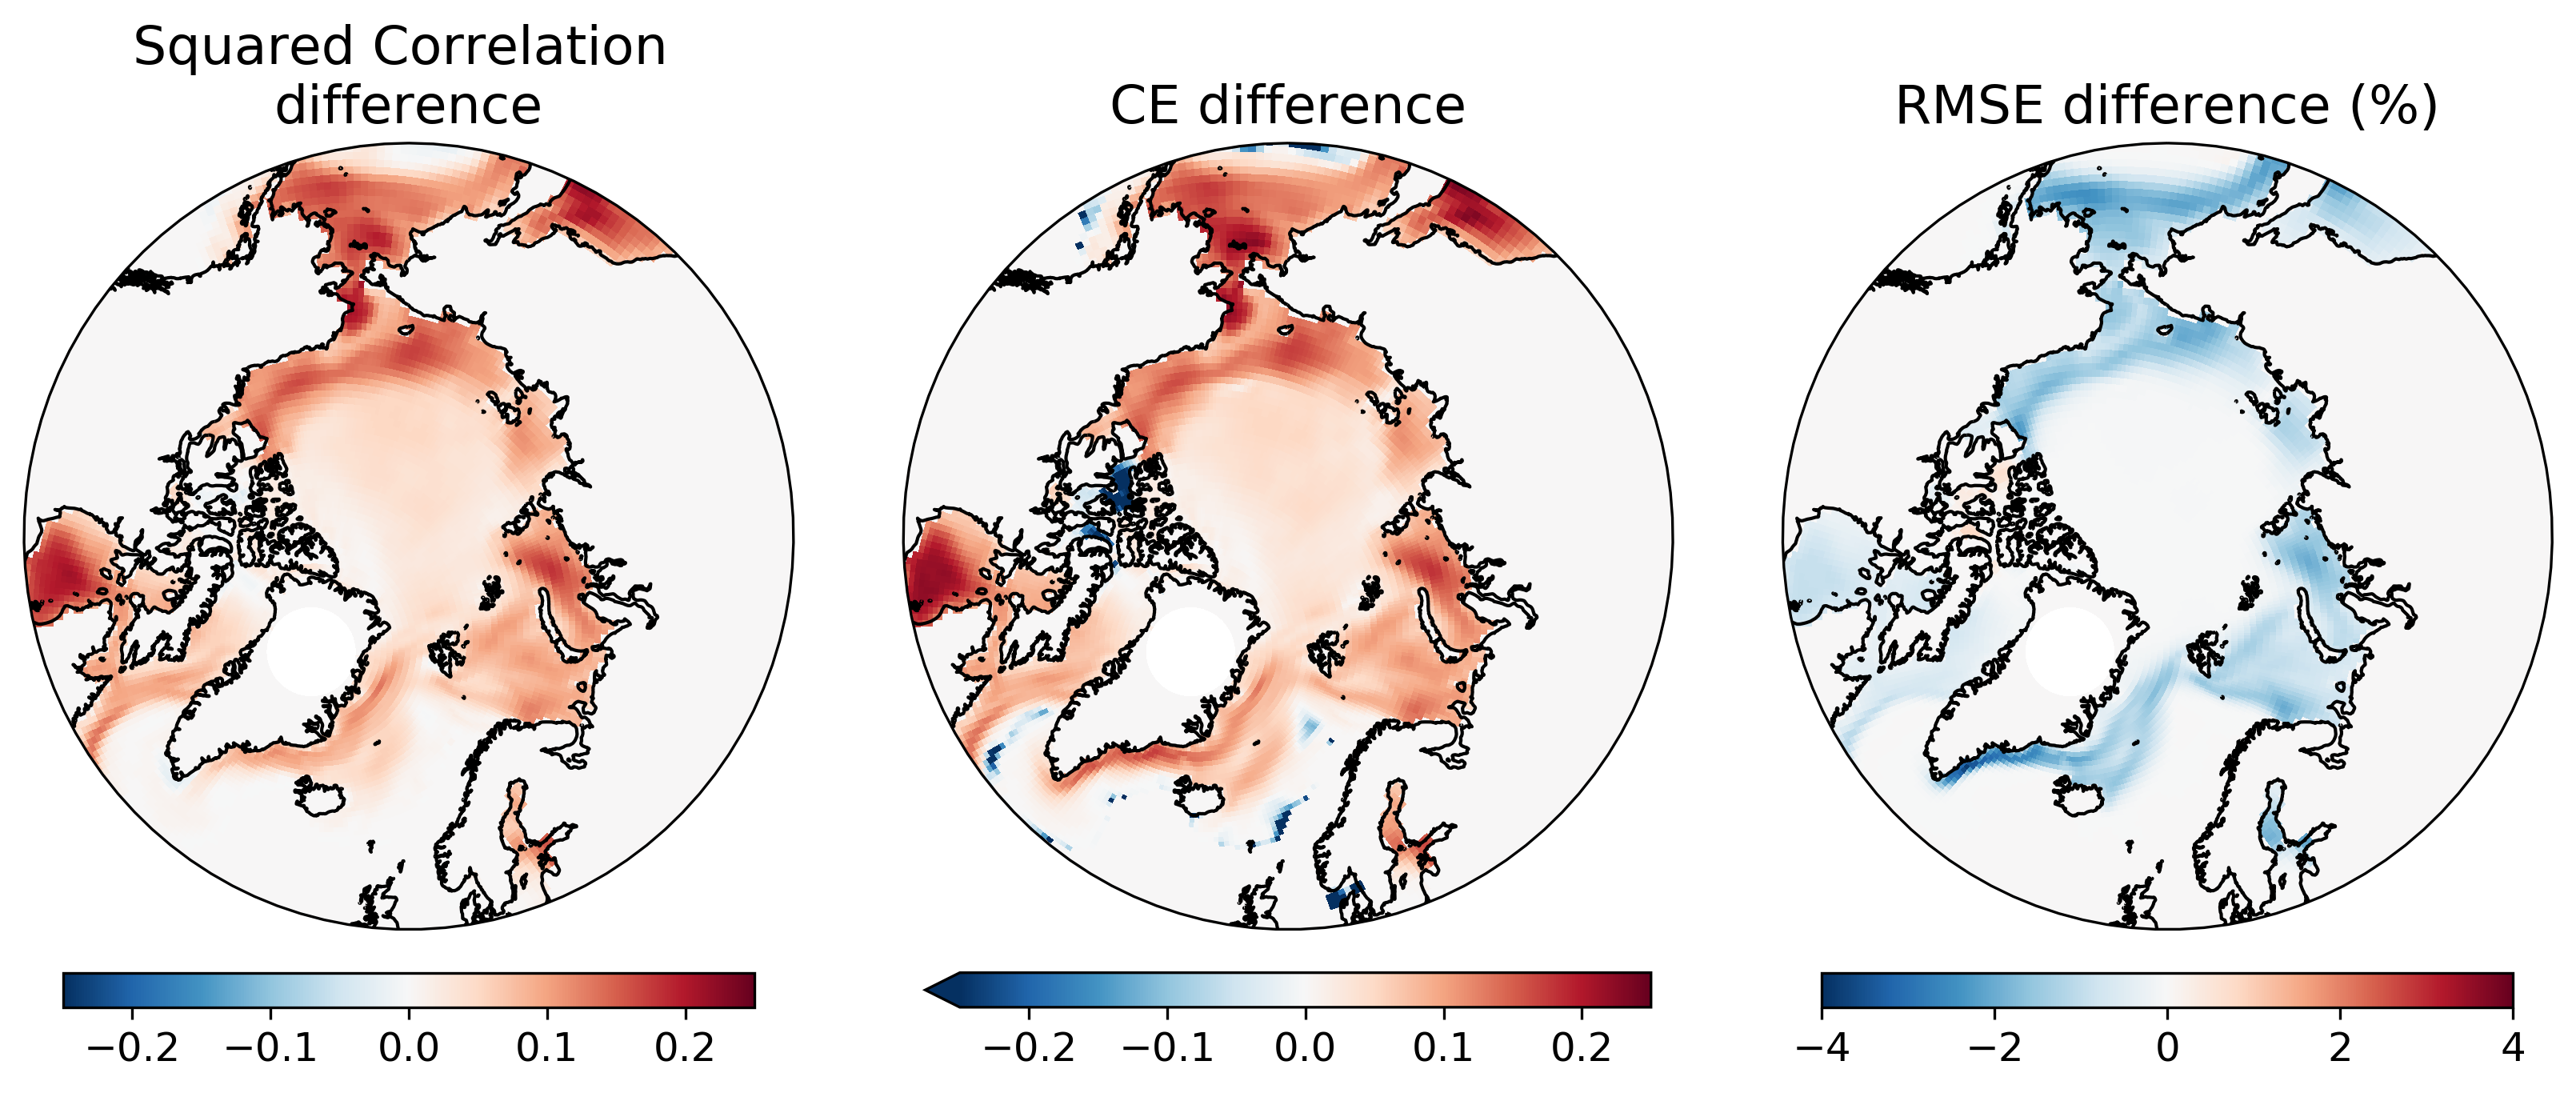

In [93]:
lag_int=1
modes = [np.nan_to_num(corr_2d_os**2-corr_ar1_2d_os**2),np.nan_to_num(ce_2d_os-ce_ar1_2d_os), 
         np.nan_to_num(rmse_2d_os-rmse_ar1_2d_os)*100]
vmin_modes = [-0.25,-0.25,-4]
vmax_modes = [0.25,0.25,4]
colors = ['RdBu_r','RdBu_r','RdBu_r','RdBu_r']
mode_name = ['Squared Correlation \ndifference','CE difference','RMSE difference (%)', 'RMSE difference']
extent = ['neither', 'min', 'neither']

lonn = np.nan_to_num(LIMd_is['var_dict']['tos']['lon'])
latt = np.nan_to_num(LIMd_is['var_dict']['tos']['lat'])

fig, axs = plt.subplots(1,3,figsize=(12,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    [field,latcyc,loncyc] = pop_add_cyclic(mode,latt,lonn)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    cf = ax[i].pcolormesh(loncyc,latcyc,
                          field,cmap=colors[i], 
                          transform=ccrs.PlateCarree(),vmin=vmin_modes[i],vmax=vmax_modes[i])
    cb = fig.colorbar(cf, ax=ax[i], orientation='horizontal',fraction=0.04, pad=0.05, extend=extent[i])
    
    cb.ax.tick_params(labelsize=12) 
    
# plt.suptitle(('LIM trained on all months: '+str(lag_int)+'\n Training years: '+
#               tcmip_os+' '+tmod_os+' '+texp_os+' '+exp_setup_os['mod_sic_filename'][-22:-13]+
#               '\nValidation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os+
#               '\n(LIM forecast - AR1 forecast)'), fontsize=16)
# plt.suptitle(('Out of Sample Validation: \n Sea-ice concentration, lag = 1 month\n'+
#              '(LIM forecast - AR1 forecast)'), fontsize=16)

fig.tight_layout(rect=[0, 0.03, 1, 0.85])

savename = './figures/LIM_spatial_skill_over_AR1_os.png'
plt.savefig(savename, bbox_inches='tight')

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


color string found. 
color string found. 
color string found. 


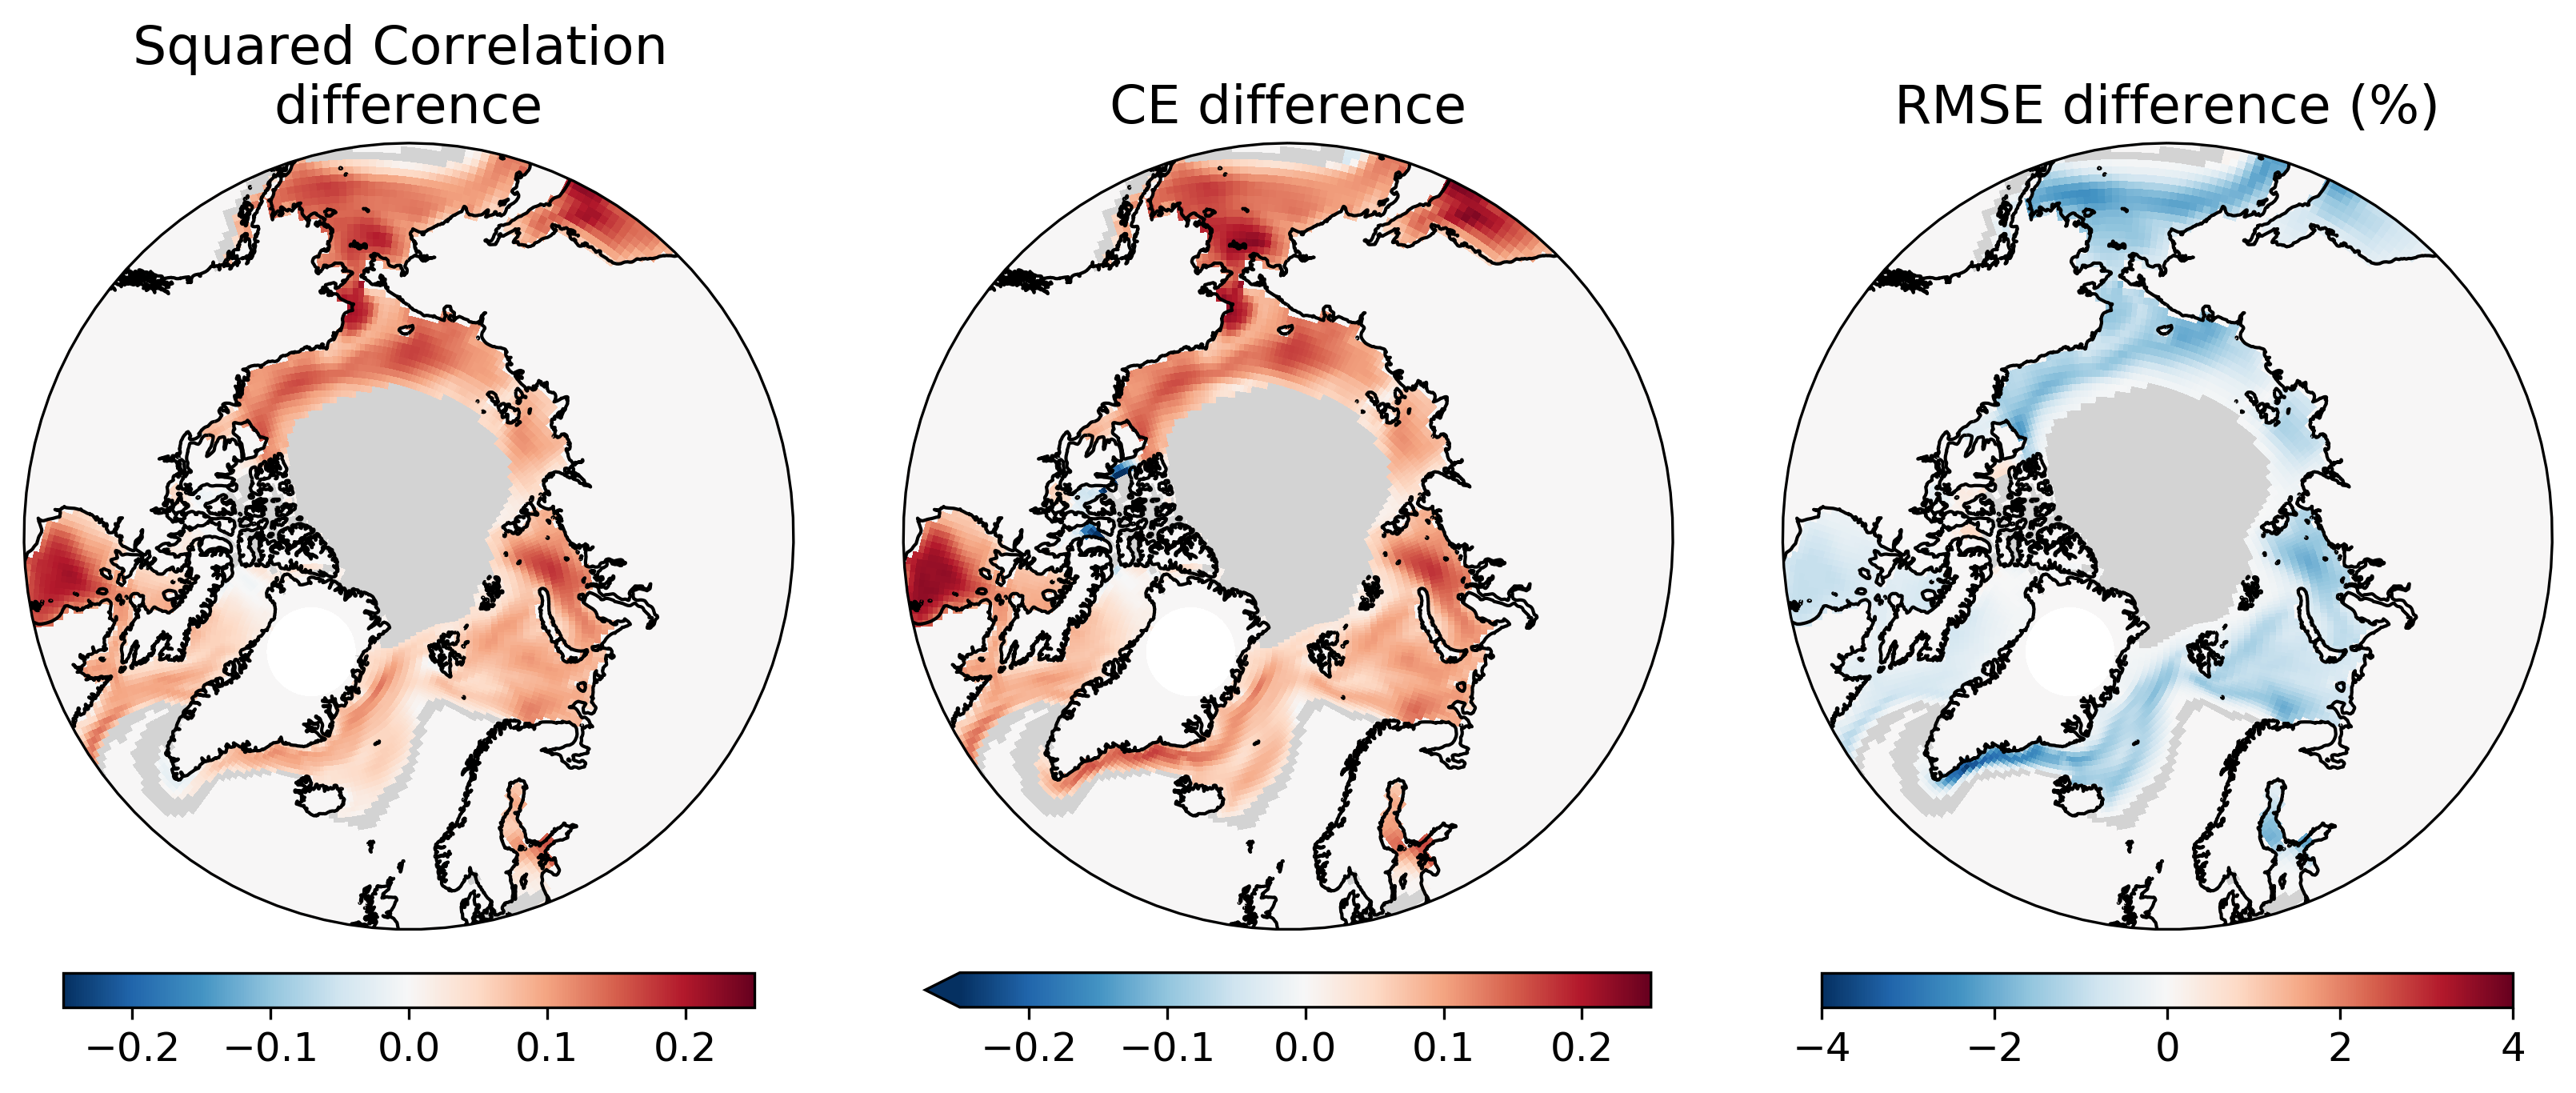

In [94]:
lag_int=1
modes = [np.nan_to_num(corr_2d_os**2-corr_ar1_2d_os**2)*mask,np.nan_to_num(ce_2d_os-ce_ar1_2d_os)*mask, 
         np.nan_to_num(rmse_2d_os-rmse_ar1_2d_os)*100*mask]
vmin_modes = [-0.25,-0.25,-4]
vmax_modes = [0.25,0.25,4]
colors = ['RdBu_r','RdBu_r','RdBu_r','RdBu_r']
mode_name = ['Squared Correlation \ndifference','CE difference','RMSE difference (%)', 'RMSE difference']
extent = ['neither', 'min', 'neither']

lonn = np.nan_to_num(LIMd_is['var_dict']['tos']['lon'])
latt = np.nan_to_num(LIMd_is['var_dict']['tos']['lat'])

fig, axs = plt.subplots(1,3,figsize=(12,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    [field,latcyc,loncyc] = pop_add_cyclic(mode,latt,lonn)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    if isinstance(colors[i], str):
        print('color string found. ')
        new_cmap_plot = matplotlib.cm.get_cmap(colors[i])
        new_cmap_plot.set_bad(color='lightgray',alpha=1)
    else: 
        print('new_cmap')
        new_cmap_plot = new_cmap
        new_cmap_plot.set_bad(color='lightgray',alpha=1)
    
    cf = ax[i].pcolormesh(loncyc,latcyc,
                          field,cmap=new_cmap_plot, 
                          transform=ccrs.PlateCarree(),vmin=vmin_modes[i],vmax=vmax_modes[i])
    cb = fig.colorbar(cf, ax=ax[i], orientation='horizontal',fraction=0.04, pad=0.05, extend=extent[i])
    
    cb.ax.tick_params(labelsize=12) 
    
# plt.suptitle(('LIM trained on all months: '+str(lag_int)+'\n Training years: '+
#               tcmip_os+' '+tmod_os+' '+texp_os+' '+exp_setup_os['mod_sic_filename'][-22:-13]+
#               '\nValidation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os+
#               '\n(LIM forecast - AR1 forecast)'), fontsize=16)
# plt.suptitle(('Out of Sample Validation: \n Sea-ice concentration, lag = 1 month\n'+
#              '(LIM forecast - AR1 forecast)'), fontsize=16)

fig.tight_layout(rect=[0, 0.03, 1, 0.85])

# savename = './figures/LIM_spatial_skill_over_AR1_os.png'
# plt.savefig(savename, bbox_inches='tight')

## Lag 3: 

In [184]:
lag_int=3

In [185]:
## Calculate validation statistics: 
[truth_anom_os, 
 forecast_anom_os] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup_os['mo'],X_var_os,
                                                           x_forecast_dcomp_os,
                                                           LIMd_os['var_dict'],insamp=exp_setup_os['Insamp'])

print('Truth_anom shape: '+str(truth_anom_os.shape))
print('Forecast_anom shape: '+str(forecast_anom_os.shape))

corr=np.zeros(truth_anom_os.shape[0])
ce=np.zeros(truth_anom_os.shape[0])

for i in range(truth_anom_os.shape[0]):
    corr[i] = np.corrcoef(truth_anom_os[i,:],np.nan_to_num(forecast_anom_os[i,:]))[0,1]
    ce[i] = LMR_utils.coefficient_efficiency(truth_anom_os[i,:],np.nan_to_num(forecast_anom_os[i,:]))
    
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_os['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

rmse = np.sqrt(np.nanmean((truth_anom_os-forecast_anom_os)**2,axis=1))
var_truth = np.nanvar(truth_anom_os,axis=1)
var_forecast = np.nanvar(forecast_anom_os,axis=1)

corr_2d_os = np.reshape(corr,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1]))
ce_2d_os = np.reshape(ce,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1]))
rmse_2d_os = np.reshape(rmse,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1]))
var_truth_os_2d = np.reshape(var_truth,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1]))
var_forecast_os_2d = np.reshape(var_forecast,(LIMd_os['var_dict'][var]['lat'].shape[0],LIMd_os['var_dict'][var]['lat'].shape[1]))

Trained using all months...


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py:550: RuntimeWarning: Mean of empty slice
  truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py:552: RuntimeWarning: Mean of empty slice
  forecast_anom = x_forecast[:,lag:] - np.nanmean(x_forecast[:,lag:],axis=1)[:,np.newaxis]
/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/kalman2/mkb22/pyLMR/LMR_

Truth_anom shape: (25600, 2397)
Forecast_anom shape: (25600, 2397)


/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Degrees of freedom <= 0 for slice.
/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Degrees of freedom <= 0 for slice.


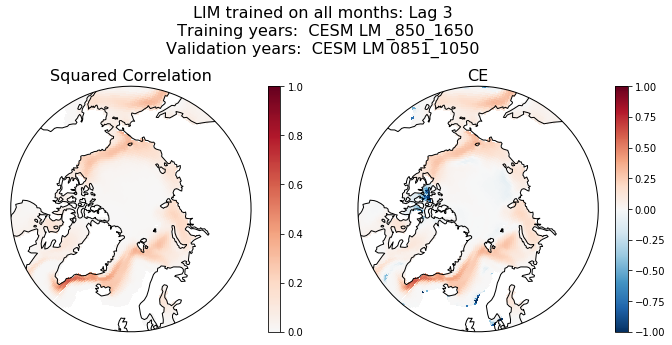

In [189]:
lag_int=3
modes = [corr_2d_os**2,ce_2d_os]
vmin_modes = [0,-1,0,-0.1,-0.1]
vmax_modes = [1,1,1,0.1,0.1]
colors = [new_cmap,'RdBu_r',new_cmap, new_cmap, new_cmap]
mode_name = ['Squared Correlation','CE', 'RMSE']

fig, axs = plt.subplots(1,2,figsize=(10,5),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    cf = ax[i].pcolormesh(np.nan_to_num(LIMd_is['var_dict']['tos']['lon']),#*lat_mask, #[:,:,0],
                          np.nan_to_num(LIMd_is['var_dict']['tos']['lat']),#*lat_mask, #[:,:,0],
                          mode,cmap=colors[i], 
                          transform=ccrs.PlateCarree(),vmin=vmin_modes[i],vmax=1)
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle(('LIM trained on all months: Lag '+str(lag_int)+'\n Training years: '+
              tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nValidation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.80])